<a href="https://colab.research.google.com/github/vijaygwu/SEAS8525/blob/main/Class_5_PixelCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Addapted from the [book](https://https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/tree/main)

This code defines two functions:

1. `sample_batch(dataset)`:
   - Takes a `dataset` object as input.
   - Retrieves a single batch from the dataset using `dataset.take(1).get_single_element()`.
   - If the batch is a tuple, it extracts the first element of the tuple.
   - Returns the batch as a NumPy array using `batch.numpy()`.

2. `display(images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None)`:
   - Takes an array of `images` and optional parameters for display configuration.
   - Normalizes the pixel values of the images to the range [0, 1] if the maximum value is greater than 1.0, or to the range [-1, 1] if the minimum value is less than 0.0.
   - Creates a figure with a specified size using `plt.figure(figsize=size)`.
   - Iterates over `n` random images from the `images` array.
   - Displays each image as a subplot using `plt.subplot(1, n, i + 1)` and `plt.imshow()`.
   - Applies the specified colormap (`cmap`) and data type (`as_type`) to the displayed images.
   - Removes the axis labels and ticks using `plt.axis("off")`.
   - If `save_to` is provided, saves the figure to the specified file path and prints a message.
   - Finally, shows the plotted images using `plt.show()`.


In [1]:
def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

In [3]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks
import matplotlib.pyplot as plt
import matplotlib

In [4]:
IMAGE_SIZE = 16
PIXEL_LEVELS = 4
N_FILTERS = 128
RESIDUAL_BLOCKS = 5
BATCH_SIZE = 128
EPOCHS = 150

In [5]:
# Load the data
(x_train, _), (_, _) = datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [6]:
# Preprocess the data
def preprocess(imgs_int):
    imgs_int = np.expand_dims(imgs_int, -1)
    imgs_int = tf.image.resize(imgs_int, (IMAGE_SIZE, IMAGE_SIZE)).numpy()
    imgs_int = (imgs_int / (256 / PIXEL_LEVELS)).astype(int)
    imgs = imgs_int.astype("float32")
    imgs = imgs / PIXEL_LEVELS
    return imgs, imgs_int


input_data, output_data = preprocess(x_train)

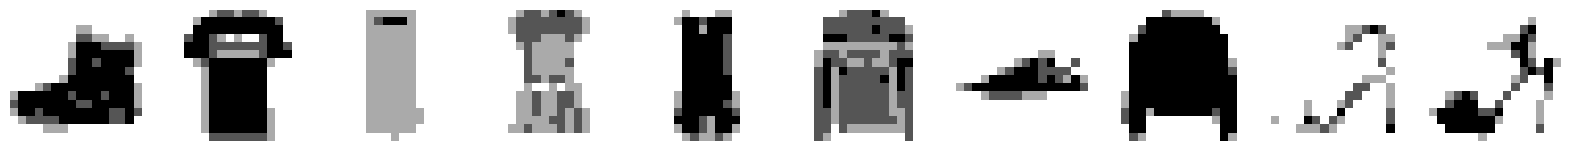

In [7]:
# Show some items of clothing from the training set
display(input_data)

The code in the following cell defines a custom layer called `MaskedConv2D` which extends the functionality of the standard 2D convolutional layer (`layers.Conv2D`) by including masking.



1. The `MaskedConv2D` class is defined as a subclass of `layers.Layer`, indicating that it is a custom layer.

2. The `__init__` method is the constructor of the class. It takes a `mask_type` parameter and any additional keyword arguments (`**kwargs`). It calls the constructor of the parent class (`super(MaskedConv2D, self).__init__()`) and initializes the `mask_type` attribute. It also creates an instance of `layers.Conv2D` with the provided `**kwargs` and assigns it to the `conv` attribute.

3. The `build` method is called when the layer is being built. It first builds the `conv` layer to initialize its kernel variables. Then, it retrieves the shape of the kernel using `self.conv.kernel.get_shape()` and creates a mask tensor (`self.mask`) with the same shape, initialized with zeros.

4. Depending on the `mask_type`, the mask is populated with ones in specific regions:
   - For the upper half of the kernel (excluding the center row), the mask values are set to 1.0.
   - For the left half of the center row (including the center pixel), the mask values are set to 1.0.
   - If the `mask_type` is "B", the center pixel of the kernel is also set to 1.0.

5. The `call` method is invoked when the layer is called with an input tensor. It multiplies the `conv` layer's kernel with the mask using element-wise multiplication (`self.conv.kernel * self.mask`). This effectively applies the mask to the kernel, zeroing out the desired regions. Then, it calls the `conv` layer with the masked kernel and returns the output.

6. The `get_config` method is used to retrieve the configuration of the layer. In this case, it simply calls the `get_config` method of the parent class and returns the configuration.

The purpose of this `MaskedConv2D` layer is to apply a mask to the convolutional kernel, allowing only certain regions of the kernel to be active during the convolution operation. This is particularly useful in architectures like PixelCNN, where the masking ensures that each pixel in the output depends only on the pixels above and to the left of it in the input, following a specific order.

In [8]:
class MaskedConv2D(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super(MaskedConv2D, self).__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.shape # Changed to .shape
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)

    def get_config(self):
        cfg = super().get_config()
        return cfg

The code in the following cell defines a custom layer called `ResidualBlock` which implements a residual block architecture commonly used in deep neural networks. Residual blocks allow the network to learn residual functions and facilitate the training of deep networks by alleviating the vanishing gradient problem.


1. The `ResidualBlock` class is defined as a subclass of `layers.Layer`, indicating that it is a custom layer.

2. The `__init__` method is the constructor of the class. It takes a `filters` parameter, which determines the number of filters in the convolutional layers, and any additional keyword arguments (`**kwargs`). It calls the constructor of the parent class (`super(ResidualBlock, self).__init__(**kwargs)`).

3. Inside the constructor, three convolutional layers are defined:
   - `self.conv1`: A standard 2D convolutional layer (`layers.Conv2D`) with `filters // 2` filters (half the input filters), kernel size of 1, and ReLU activation.
   - `self.pixel_conv`: An instance of the `MaskedConv2D` layer (defined in the previous code snippet) with mask type "B", `filters // 2` filters (half the input filters), kernel size of 3, ReLU activation, and "same" padding.
   - `self.conv2`: Another standard 2D convolutional layer with `filters` filters (same as the input filters), kernel size of 1, and ReLU activation.

4. The `call` method is invoked when the layer is called with an input tensor. It defines the forward pass of the residual block:
   - The input tensor is passed through `self.conv1`, followed by `self.pixel_conv`, and then `self.conv2`.
   - The output of `self.conv2` is added element-wise to the original input tensor using `layers.add([inputs, x])`, creating the residual connection.
   - The result of the element-wise addition is returned as the output of the residual block.

5. The `get_config` method is used to retrieve the configuration of the layer. In this case, it simply calls the `get_config` method of the parent class and returns the configuration.

The purpose of this `ResidualBlock` is to learn residual functions by allowing the network to pass information from the input directly to the output through the residual connection. The block consists of two branches:
- The main branch applies a series of convolutional operations (conv1 → pixel_conv → conv2) to the input.
- The residual branch simply passes the input directly to the output.

The outputs of both branches are then added element-wise, enabling the network to learn the residual function. This residual connection helps in training deep networks by allowing the gradients to flow more easily through the network, mitigating the vanishing gradient problem.

The `MaskedConv2D` layer used in the `pixel_conv` ensures that the convolution operation follows a specific masking pattern, which is useful in a PixelCNN.

In [9]:
class ResidualBlock(layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = layers.Conv2D(
            filters=filters // 2, kernel_size=1, activation="relu"
        )
        self.pixel_conv = MaskedConv2D(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return layers.add([inputs, x])

    def get_config(self):
        cfg = super().get_config()
        return cfg

The code below defines the architecture of a PixelCNN model using the Keras functional API.

1. `inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))`:
   - This line defines the input layer of the model using `layers.Input`.
   - The input shape is specified as `(IMAGE_SIZE, IMAGE_SIZE, 1)`, indicating that the input images have a height and width of `IMAGE_SIZE` and a single channel (grayscale).

2. `x = MaskedConv2D(mask_type="A", filters=N_FILTERS, kernel_size=7, activation="relu", padding="same")(inputs)`:
   - The input tensor is passed through a `MaskedConv2D` layer with mask type "A", `N_FILTERS` filters, a kernel size of 7, ReLU activation, and "same" padding.
   - This layer applies a masked convolution operation to the input, allowing the model to capture local dependencies.

3. `for _ in range(RESIDUAL_BLOCKS): x = ResidualBlock(filters=N_FILTERS)(x)`:
   - This loop creates a stack of `RESIDUAL_BLOCKS` residual blocks.
   - Each residual block is created using the `ResidualBlock` layer defined in the previous code snippet, with `N_FILTERS` filters.
   - The output of each residual block is assigned back to `x`, forming a deep residual network.

4. `for _ in range(2): x = MaskedConv2D(mask_type="B", filters=N_FILTERS, kernel_size=1, strides=1, activation="relu", padding="valid")(x)`:
   - This loop applies two additional `MaskedConv2D` layers with mask type "B", `N_FILTERS` filters, a kernel size of 1, stride of 1, ReLU activation, and "valid" padding.
   - These layers further process the output of the residual blocks.

5. `out = layers.Conv2D(filters=PIXEL_LEVELS, kernel_size=1, strides=1, activation="softmax", padding="valid")(x)`:
   - The final layer is a standard 2D convolutional layer (`layers.Conv2D`) with `PIXEL_LEVELS` filters, a kernel size of 1, stride of 1, softmax activation, and "valid" padding.
   - This layer produces the output of the model, representing the probability distribution over the pixel values.

6. `pixel_cnn = models.Model(inputs, out)`:
   - The `pixel_cnn` model is created using `models.Model`, specifying the input tensor (`inputs`) and the output tensor (`out`).
   - This defines the complete PixelCNN model architecture.

7. `pixel_cnn.summary()`:
   - This line prints a summary of the PixelCNN model architecture, displaying the layers, their output shapes, and the number of parameters in each layer.

The resulting `pixel_cnn` model is a deep convolutional neural network that learns to generate images pixel by pixel. The architecture consists of a stack of masked convolutional layers and residual blocks, which capture the dependencies between pixels and allow the model to generate coherent and realistic images.

The use of masked convolutions ensures that the model follows a specific order in generating pixels, where each pixel depends only on the pixels above and to the left of it in the image.

In [10]:
inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))
x = MaskedConv2D(
    mask_type="A",
    filters=N_FILTERS,
    kernel_size=7,
    activation="relu",
    padding="same",
)(inputs)

for _ in range(RESIDUAL_BLOCKS):
    x = ResidualBlock(filters=N_FILTERS)(x)

for _ in range(2):
    x = MaskedConv2D(
        mask_type="B",
        filters=N_FILTERS,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = layers.Conv2D(
    filters=PIXEL_LEVELS,
    kernel_size=1,
    strides=1,
    activation="softmax",
    padding="valid",
)(x)

pixel_cnn = models.Model(inputs, out)
pixel_cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masked_conv2d (MaskedConv2D)    │ (None, 16, 16, 128)    │         6,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block (ResidualBlock)  │ (None, 16, 16, 128)    │        53,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_1                │ (None, 16, 16, 128)    │        53,504 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_2                │ (None, 16, 16, 128)    │        53,504 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_3                │ (None, 16, 16, 128)    │        53,504 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_4                │ (None, 16, 16, 128)    │        53,504 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masked_conv2d_6 (MaskedConv2D)  │ (None, 16, 16, 128)    │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masked_conv2d_7 (MaskedConv2D)  │ (None, 16, 16, 128)    │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 16, 16, 4)      │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 307,460 (1.17 MB)

 Trainable params: 307,460 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
adam = optimizers.Adam(learning_rate=0.0005)
pixel_cnn.compile(optimizer=adam, loss="sparse_categorical_crossentropy")

In [12]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def sample_from(self, probs, temperature):  # <2>
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs)

    def generate(self, temperature):
        generated_images = np.zeros(
            shape=(self.num_img,) + (pixel_cnn.input_shape)[1:]
        )
        batch, rows, cols, channels = generated_images.shape

        for row in range(rows):
            for col in range(cols):
                for channel in range(channels):
                    probs = self.model.predict(generated_images, verbose=0)[
                        :, row, col, :
                    ]
                    generated_images[:, row, col, channel] = [
                        self.sample_from(x, temperature) for x in probs
                    ]
                    generated_images[:, row, col, channel] /= PIXEL_LEVELS

        return generated_images

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.generate(temperature=1.0)
        display(
            generated_images,
            save_to="/content/images/generated_img_%03d.png" % (epoch),
        )


img_generator_callback = ImageGenerator(num_img=10)

In [13]:
!mkdir ./images

Epoch 1/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6356
Saved to /content/images/generated_img_000.png


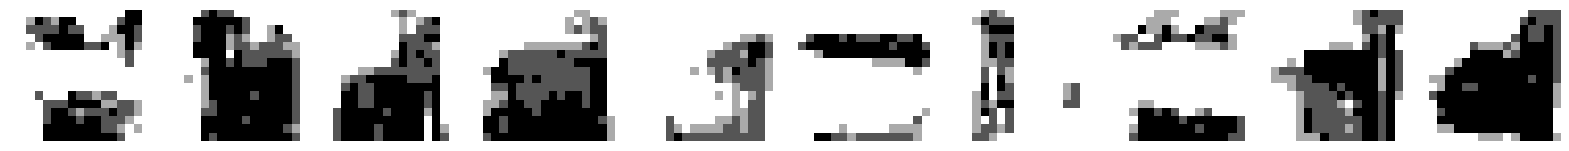

469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 52ms/step - loss: 0.6353
Epoch 2/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4050
Saved to /content/images/generated_img_001.png


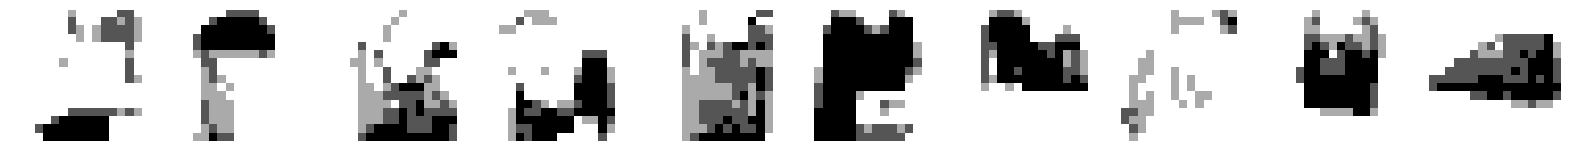

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.4050
Epoch 3/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3907
Saved to /content/images/generated_img_002.png


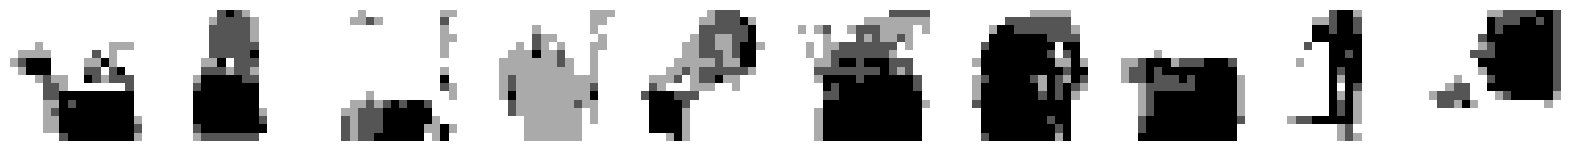

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3907
Epoch 4/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3824
Saved to /content/images/generated_img_003.png


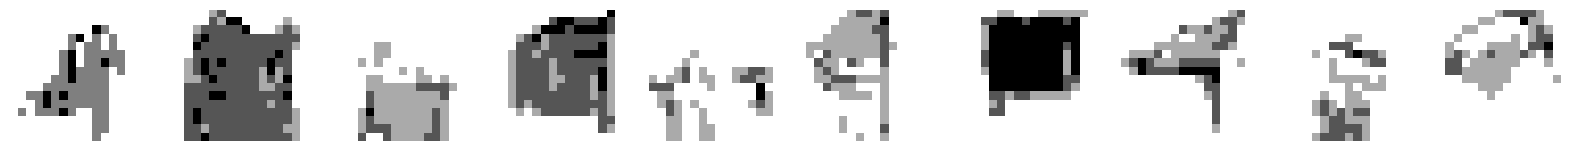

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3824
Epoch 5/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3771
Saved to /content/images/generated_img_004.png


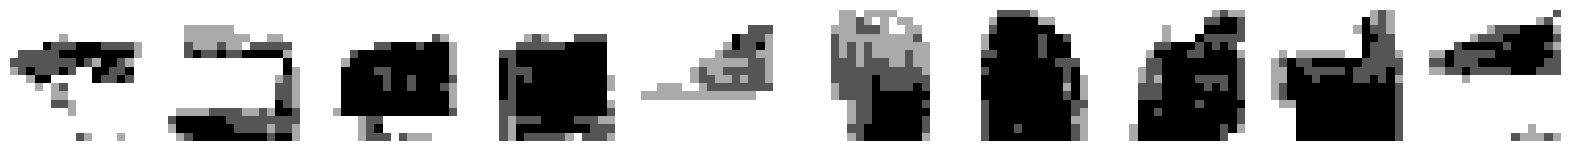

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3771
Epoch 6/150
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3731
Saved to /content/images/generated_img_005.png


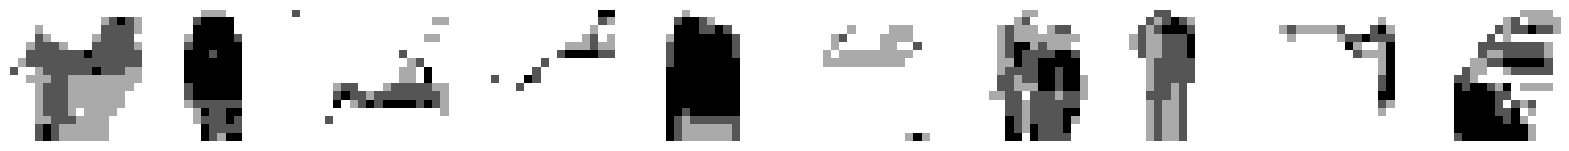

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3731
Epoch 7/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3702
Saved to /content/images/generated_img_006.png


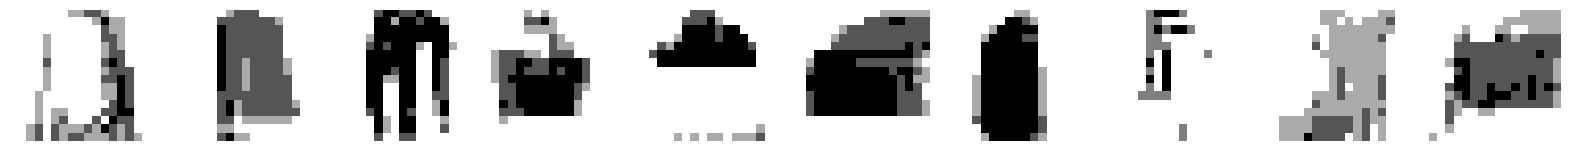

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3702
Epoch 8/150
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3687
Saved to /content/images/generated_img_007.png


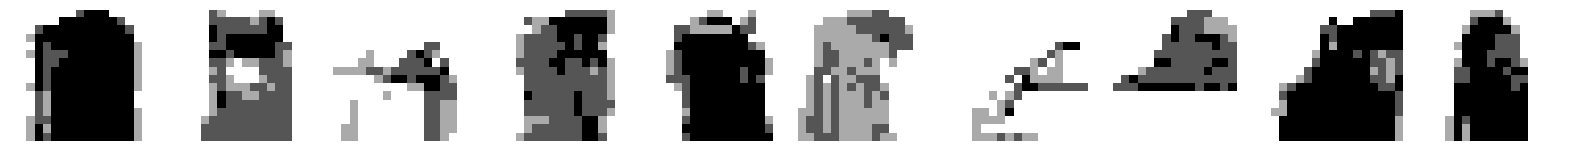

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3687
Epoch 9/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3654
Saved to /content/images/generated_img_008.png


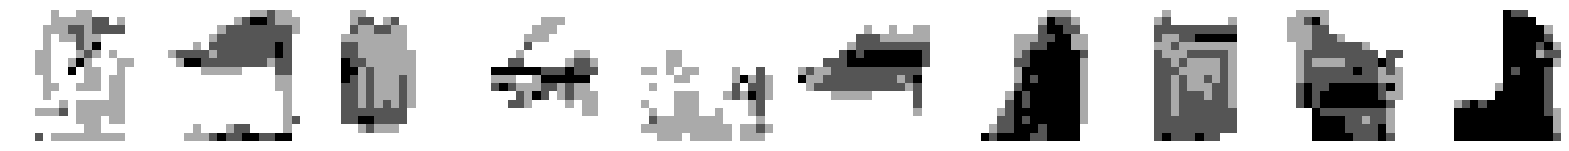

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3654
Epoch 10/150
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3626
Saved to /content/images/generated_img_009.png


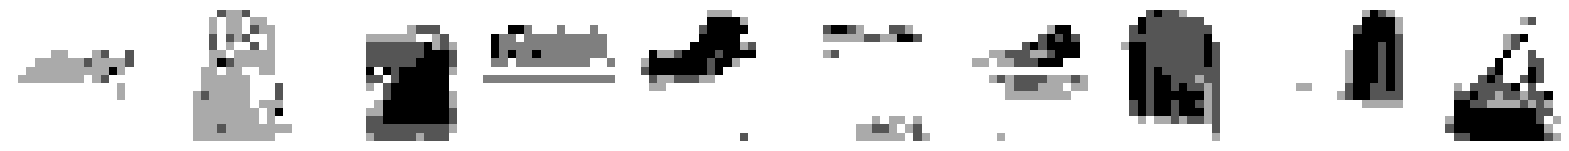

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3625
Epoch 11/150
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3600
Saved to /content/images/generated_img_010.png


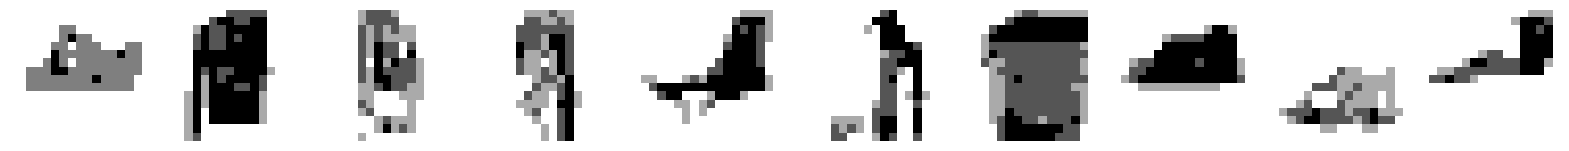

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.3600
Epoch 12/150
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3579
Saved to /content/images/generated_img_011.png


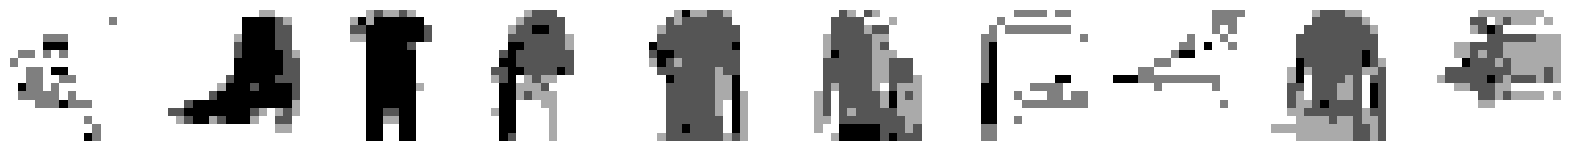

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3579
Epoch 13/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3574
Saved to /content/images/generated_img_012.png


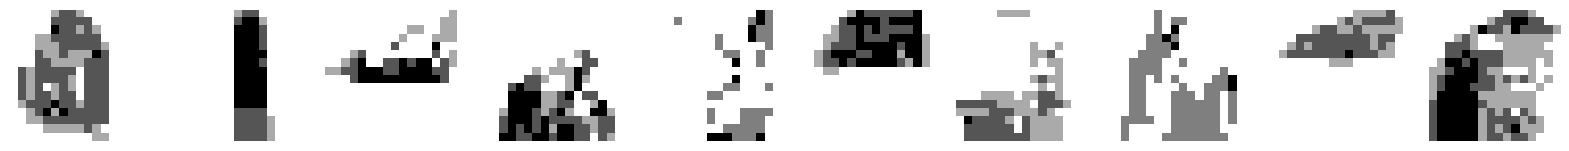

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3574
Epoch 14/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3549
Saved to /content/images/generated_img_013.png


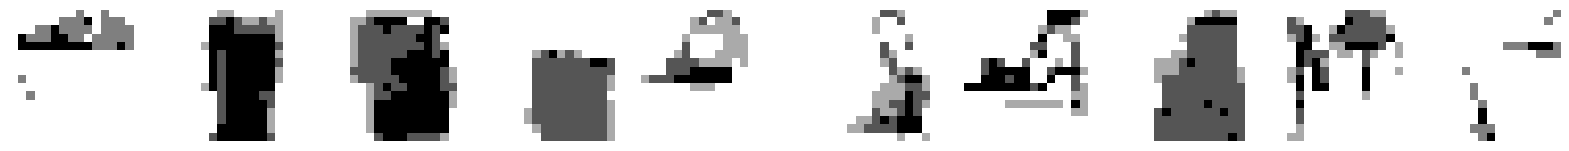

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3549
Epoch 15/150
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3539
Saved to /content/images/generated_img_014.png


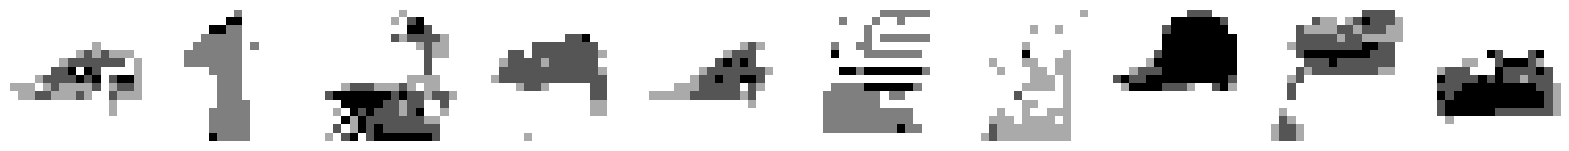

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3539
Epoch 16/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3529
Saved to /content/images/generated_img_015.png


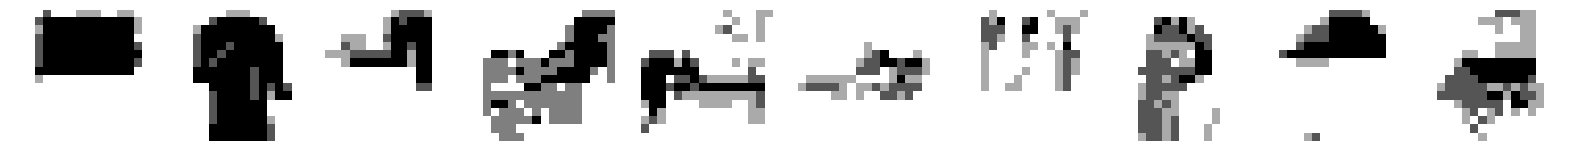

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3529
Epoch 17/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3514
Saved to /content/images/generated_img_016.png


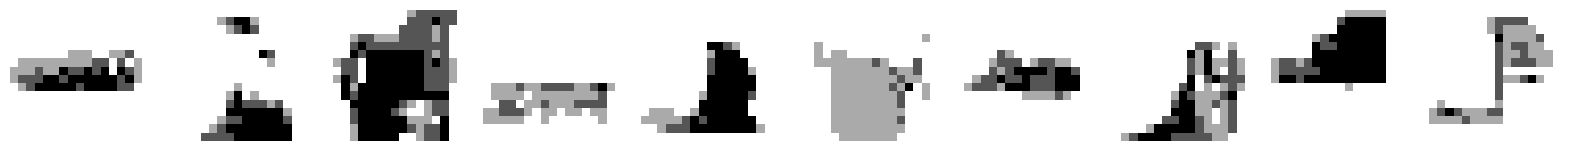

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 0.3514
Epoch 18/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3512
Saved to /content/images/generated_img_017.png


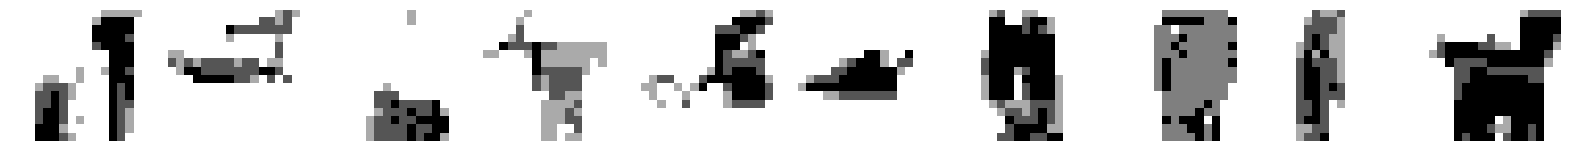

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3512
Epoch 19/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3490
Saved to /content/images/generated_img_018.png


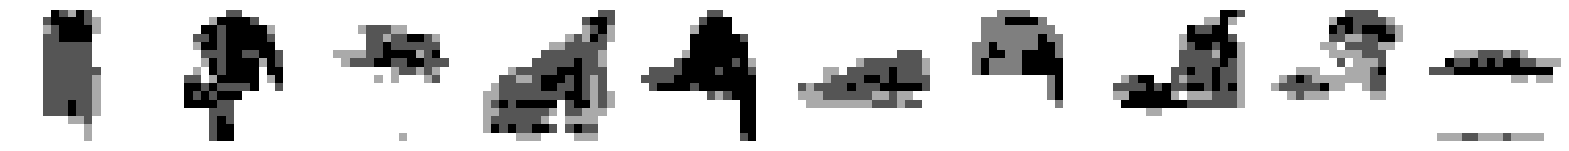

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3490
Epoch 20/150
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3482
Saved to /content/images/generated_img_019.png


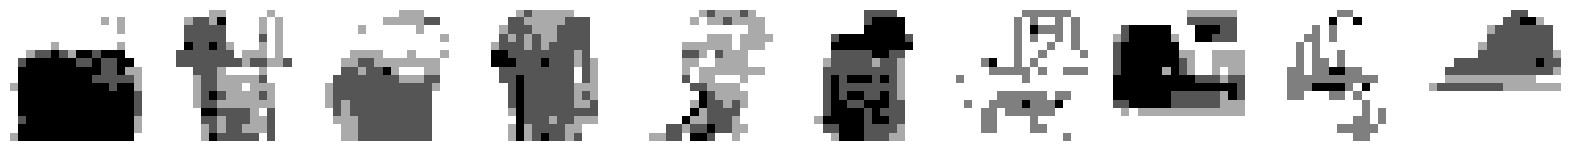

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3483
Epoch 21/150
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3471
Saved to /content/images/generated_img_020.png


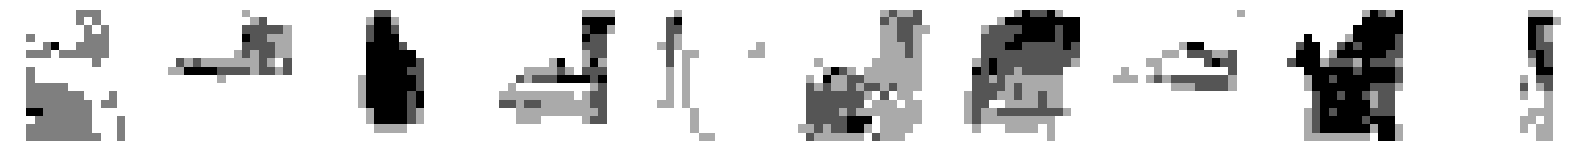

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3471
Epoch 22/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3460
Saved to /content/images/generated_img_021.png


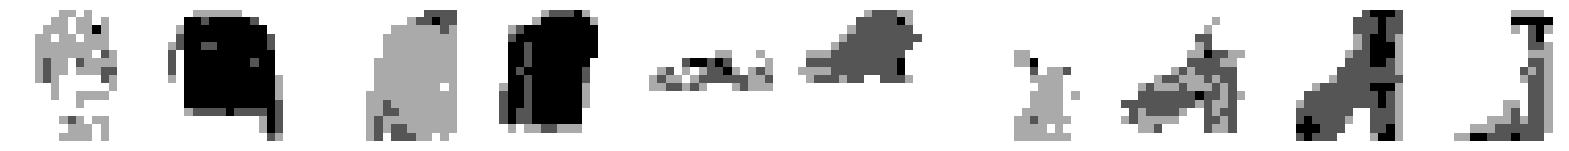

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 0.3460
Epoch 23/150
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3460
Saved to /content/images/generated_img_022.png


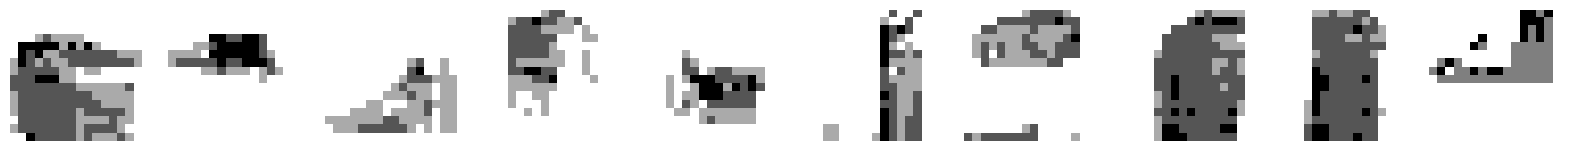

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3460
Epoch 24/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3448
Saved to /content/images/generated_img_023.png


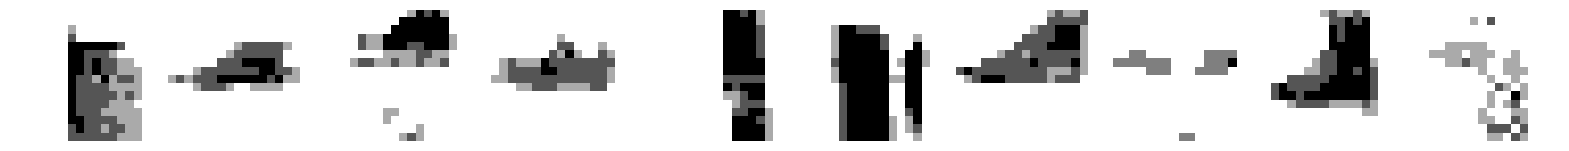

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3448
Epoch 25/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3446
Saved to /content/images/generated_img_024.png


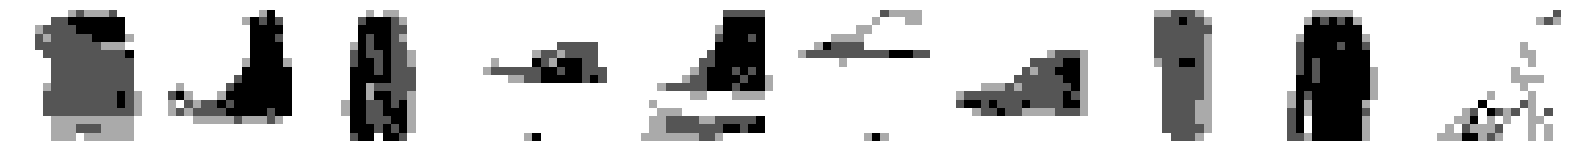

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.3446
Epoch 26/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3447
Saved to /content/images/generated_img_025.png


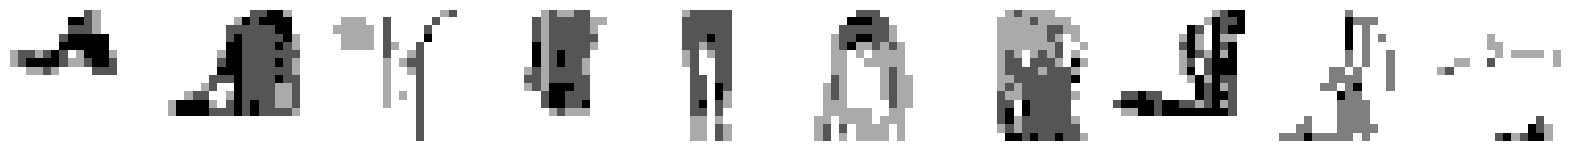

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 0.3447
Epoch 27/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3440
Saved to /content/images/generated_img_026.png


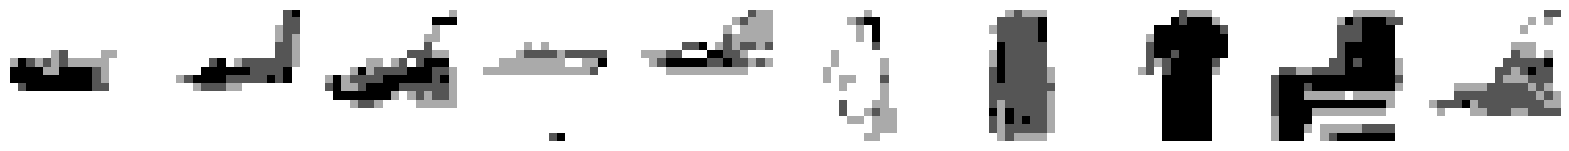

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3440
Epoch 28/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3437
Saved to /content/images/generated_img_027.png


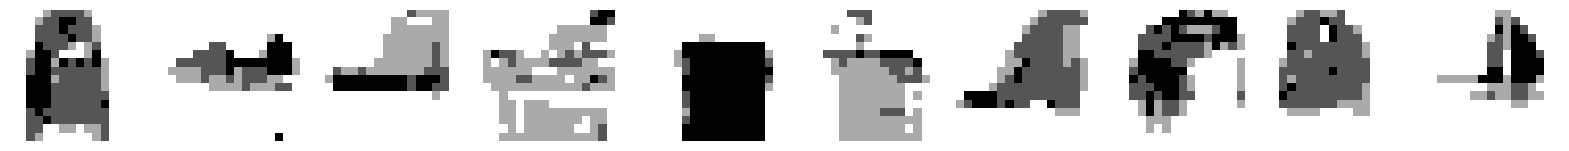

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3437
Epoch 29/150
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3425
Saved to /content/images/generated_img_028.png


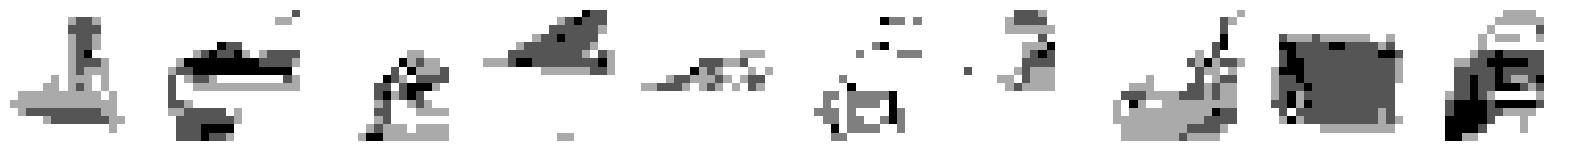

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3425
Epoch 30/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3414
Saved to /content/images/generated_img_029.png


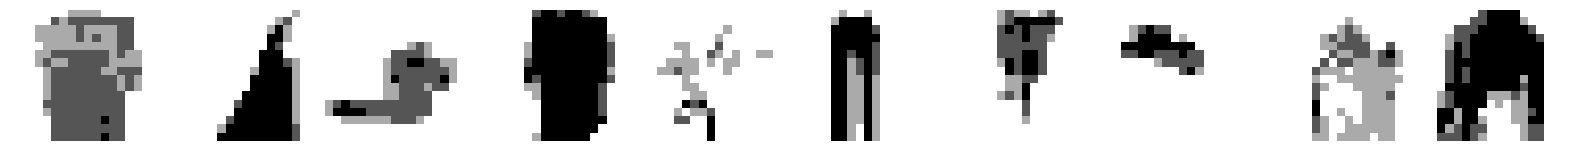

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.3414
Epoch 31/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3408
Saved to /content/images/generated_img_030.png


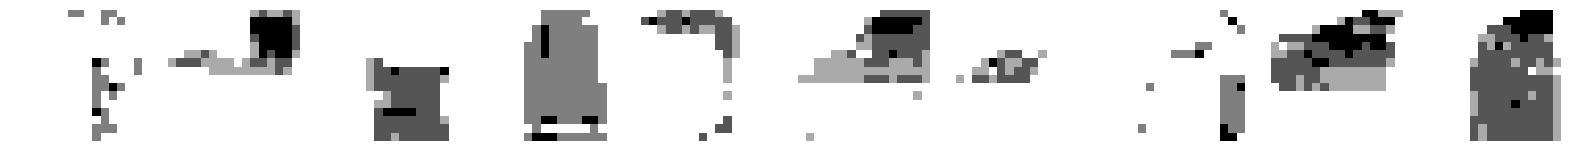

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3408
Epoch 32/150
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3414
Saved to /content/images/generated_img_031.png


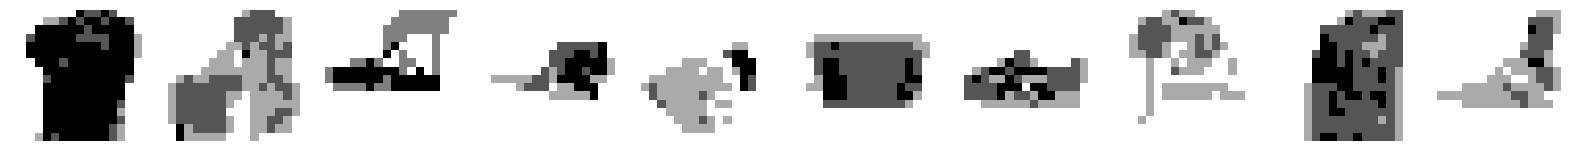

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 0.3414
Epoch 33/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3411
Saved to /content/images/generated_img_032.png


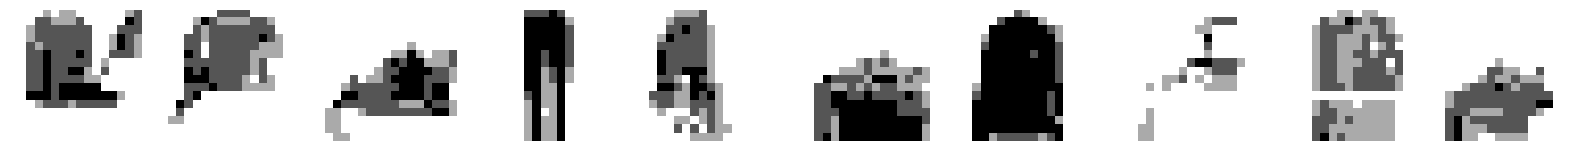

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3411
Epoch 34/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3400
Saved to /content/images/generated_img_033.png


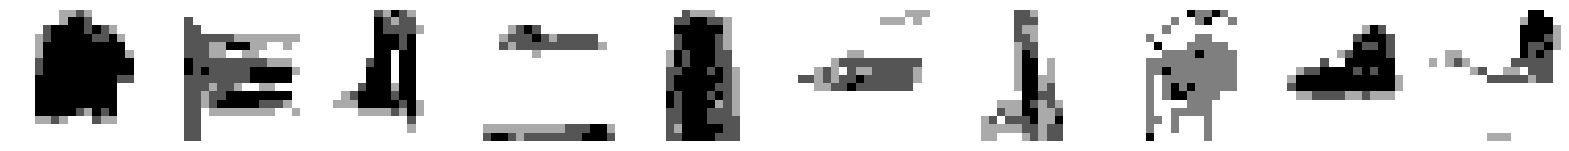

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3400
Epoch 35/150
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3400
Saved to /content/images/generated_img_034.png


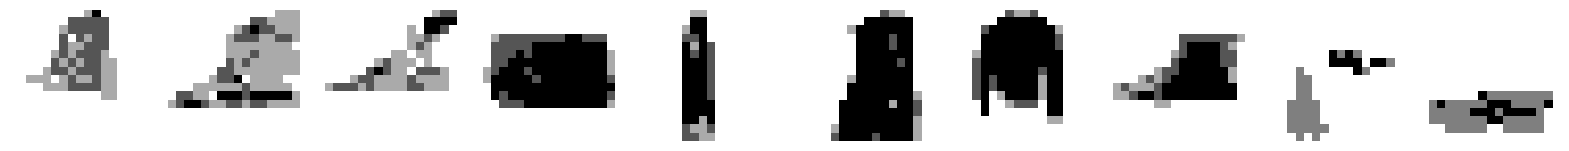

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.3400
Epoch 36/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3391
Saved to /content/images/generated_img_035.png


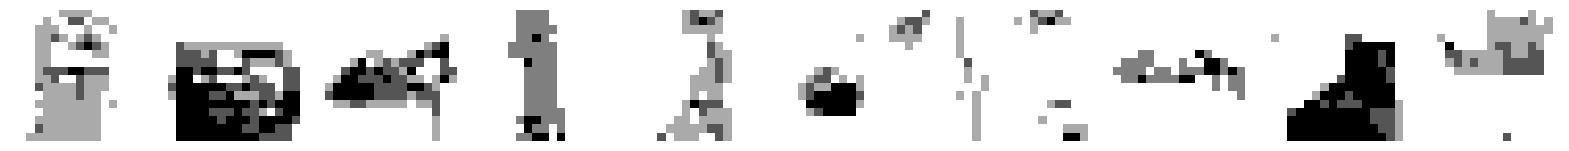

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3391
Epoch 37/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3397
Saved to /content/images/generated_img_036.png


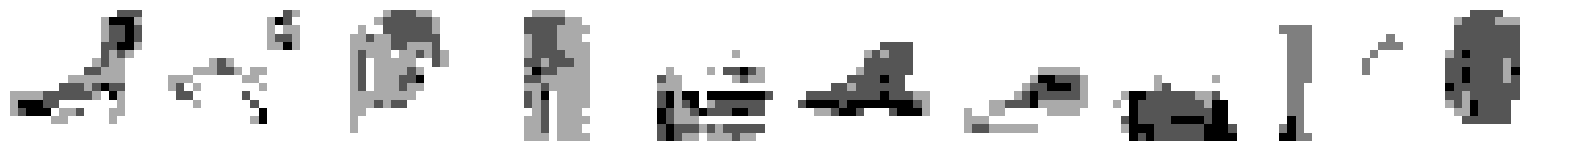

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3397
Epoch 38/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3377
Saved to /content/images/generated_img_037.png


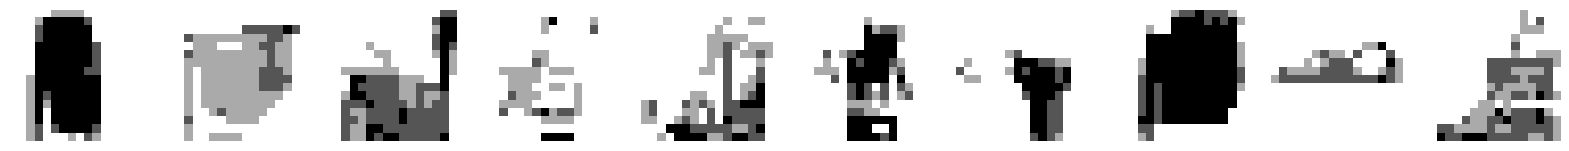

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3377
Epoch 39/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3391
Saved to /content/images/generated_img_038.png


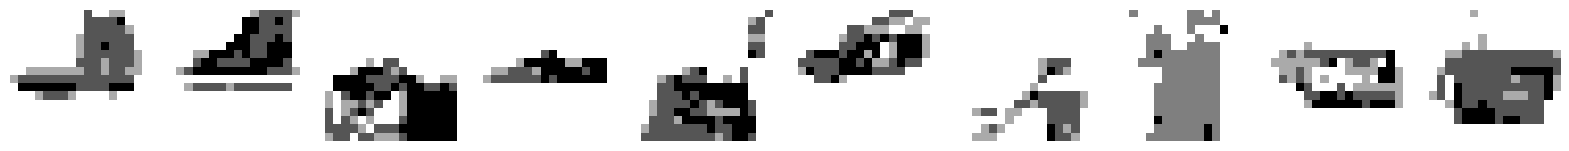

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.3391
Epoch 40/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3366
Saved to /content/images/generated_img_039.png


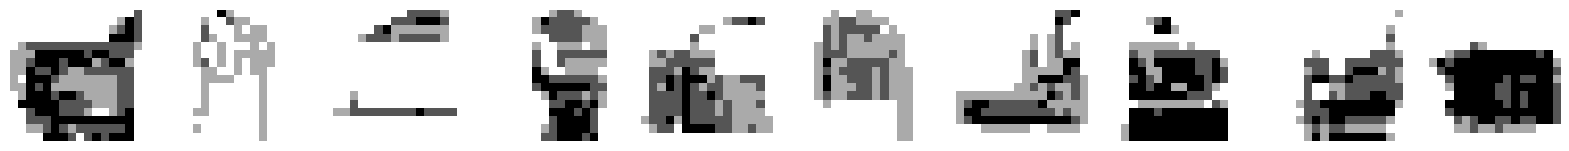

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3366
Epoch 41/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3383
Saved to /content/images/generated_img_040.png


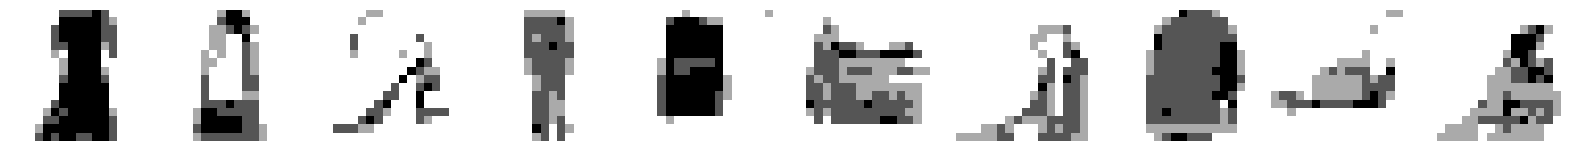

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3383
Epoch 42/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3376
Saved to /content/images/generated_img_041.png


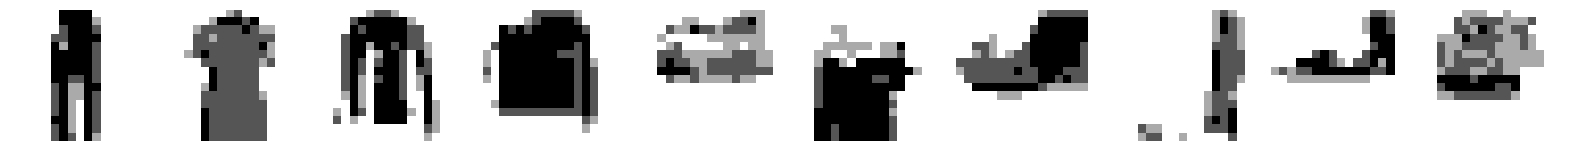

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3376
Epoch 43/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3371
Saved to /content/images/generated_img_042.png


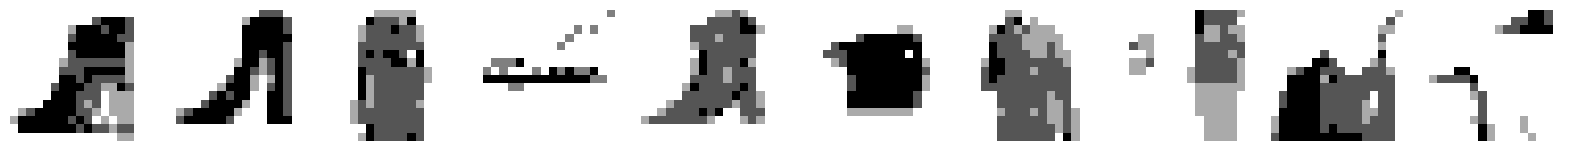

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3371
Epoch 44/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3362
Saved to /content/images/generated_img_043.png


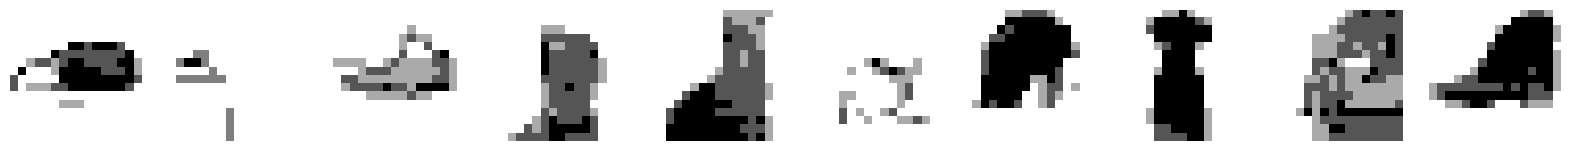

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.3362
Epoch 45/150
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3351
Saved to /content/images/generated_img_044.png


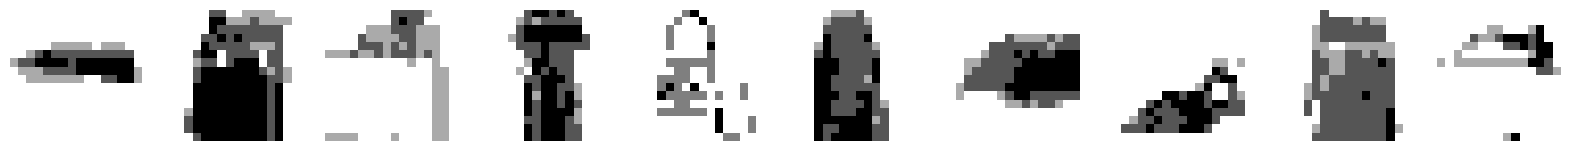

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3351
Epoch 46/150
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3356
Saved to /content/images/generated_img_045.png


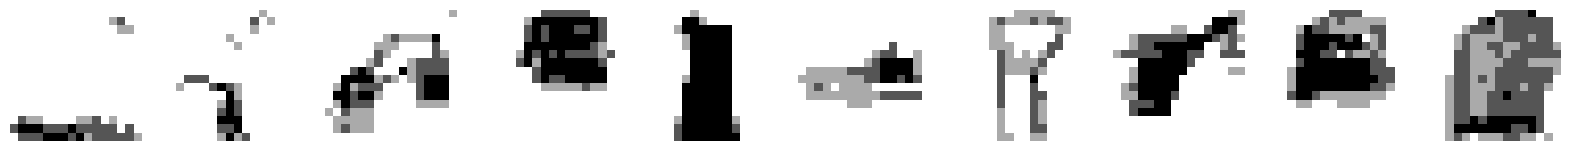

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3356
Epoch 47/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3358
Saved to /content/images/generated_img_046.png


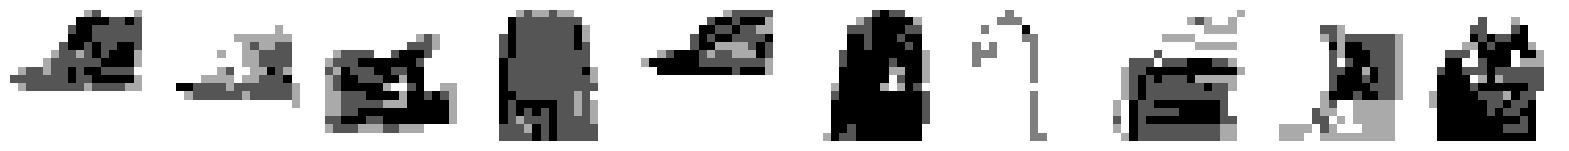

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3358
Epoch 48/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3352
Saved to /content/images/generated_img_047.png


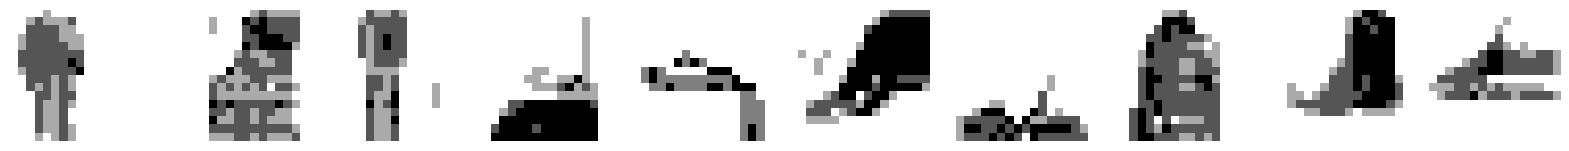

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3352
Epoch 49/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3350
Saved to /content/images/generated_img_048.png


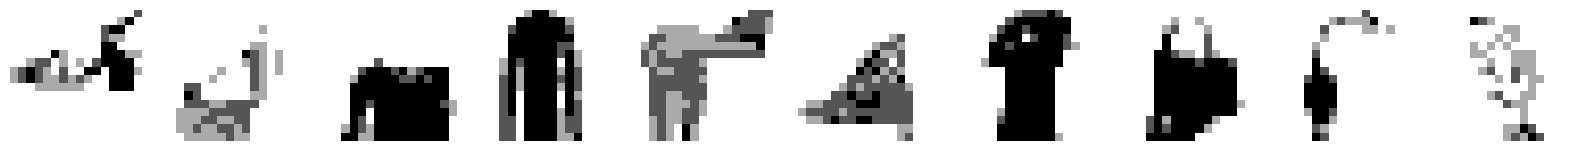

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.3350
Epoch 50/150
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3341
Saved to /content/images/generated_img_049.png


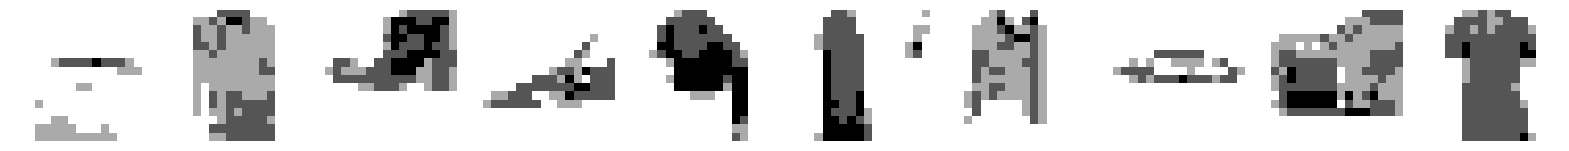

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3341
Epoch 51/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3347
Saved to /content/images/generated_img_050.png


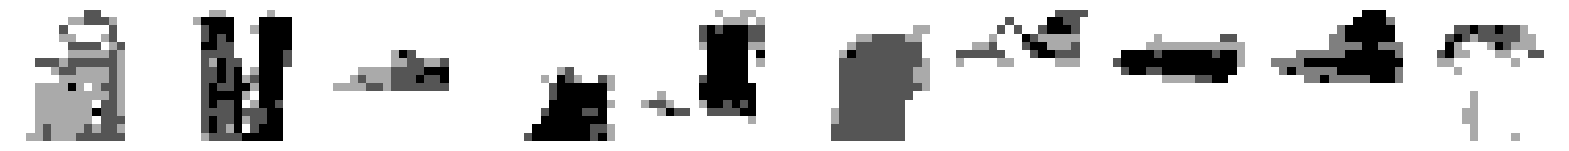

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3347
Epoch 52/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3352
Saved to /content/images/generated_img_051.png


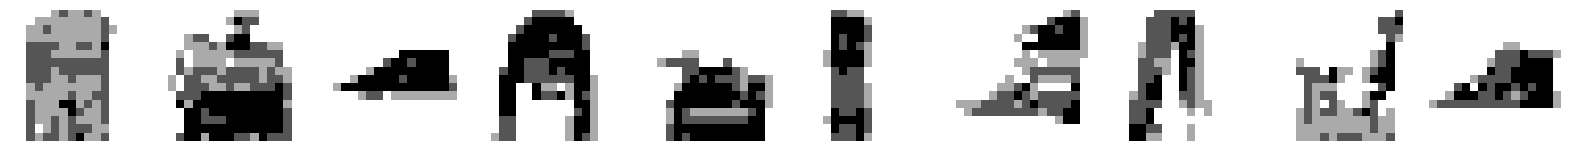

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3352
Epoch 53/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3340
Saved to /content/images/generated_img_052.png


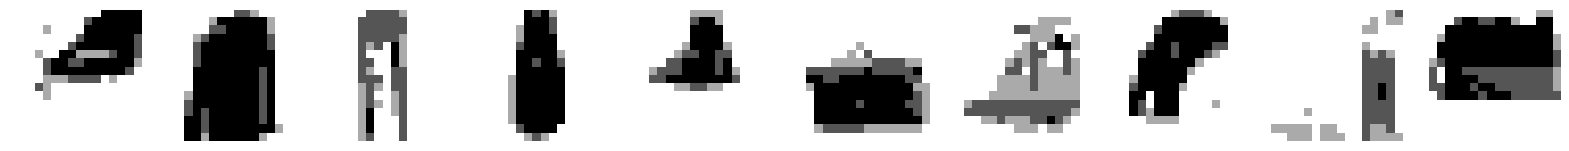

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - loss: 0.3340
Epoch 54/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3332
Saved to /content/images/generated_img_053.png


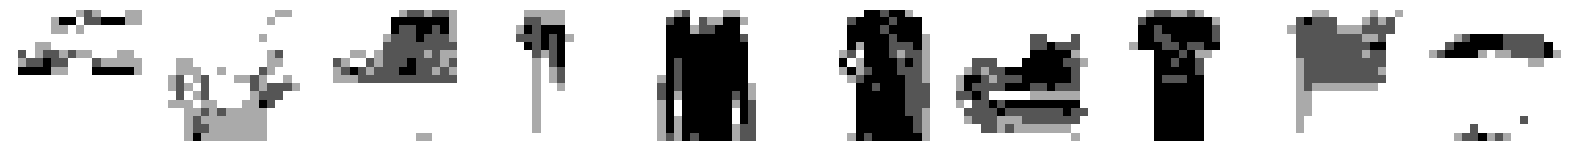

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3332
Epoch 55/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3332
Saved to /content/images/generated_img_054.png


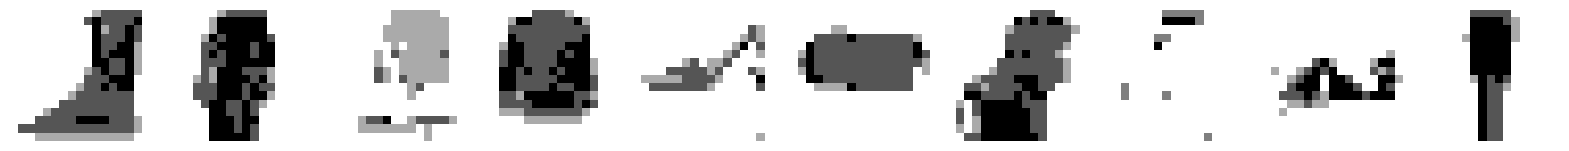

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3332
Epoch 56/150
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3336
Saved to /content/images/generated_img_055.png


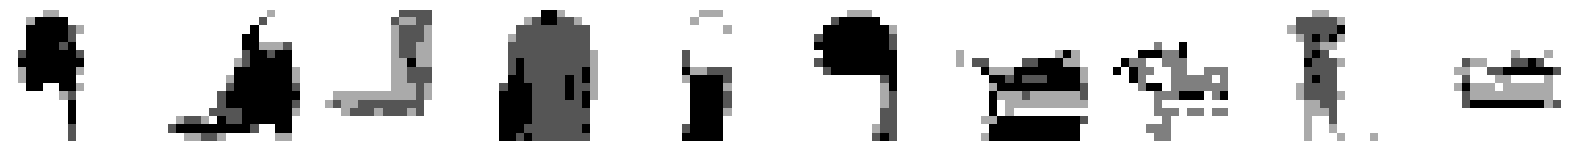

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3336
Epoch 57/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3334
Saved to /content/images/generated_img_056.png


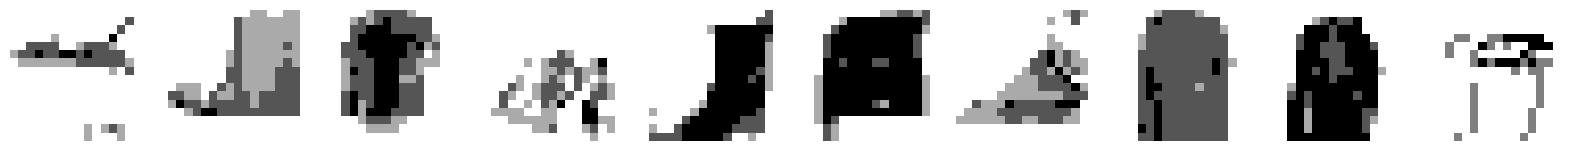

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 0.3334
Epoch 58/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3333
Saved to /content/images/generated_img_057.png


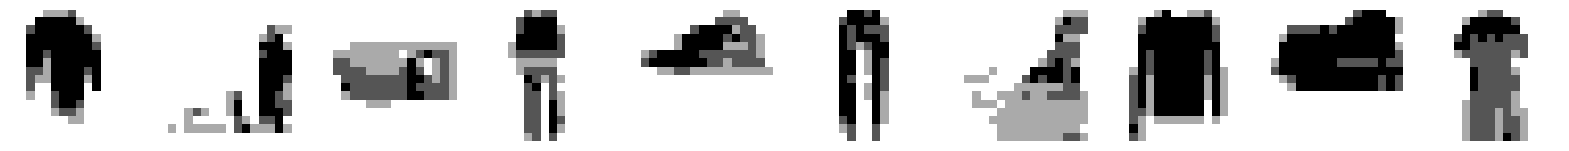

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.3333
Epoch 59/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3321
Saved to /content/images/generated_img_058.png


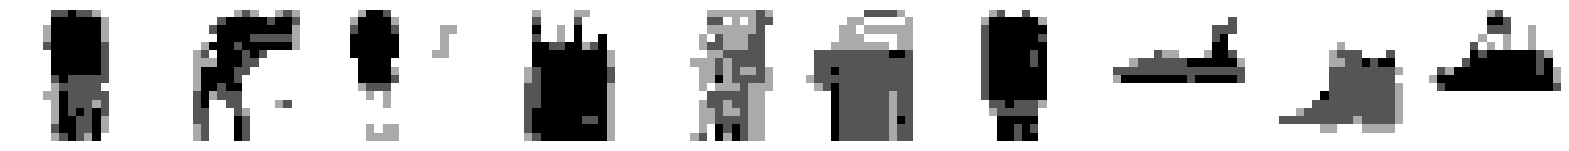

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3321
Epoch 60/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3329
Saved to /content/images/generated_img_059.png


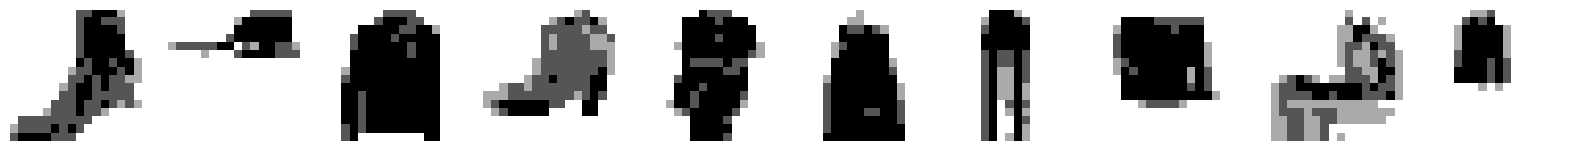

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3329
Epoch 61/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3320
Saved to /content/images/generated_img_060.png


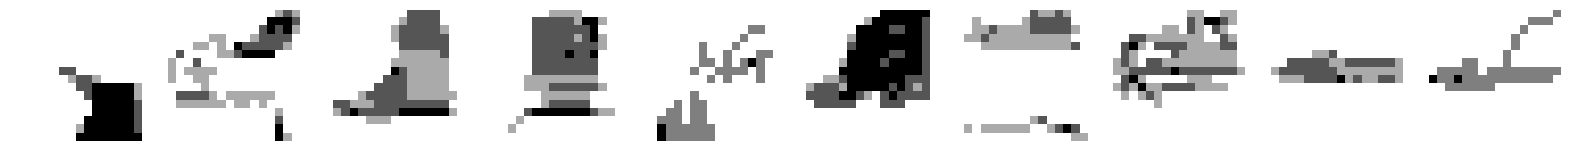

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3320
Epoch 62/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3321
Saved to /content/images/generated_img_061.png


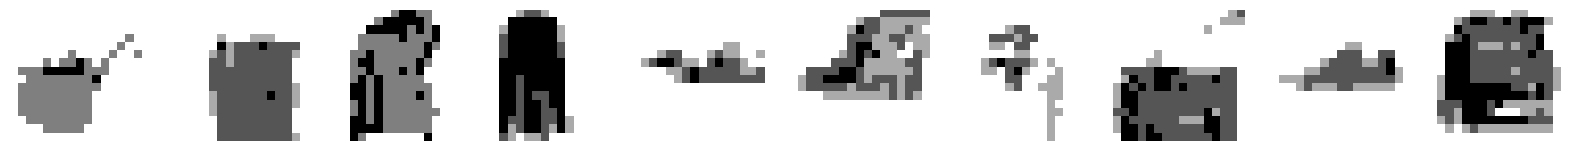

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3321
Epoch 63/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3315
Saved to /content/images/generated_img_062.png


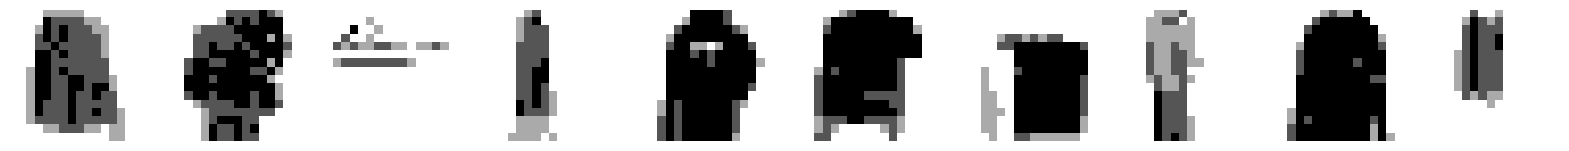

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.3315
Epoch 64/150
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3320
Saved to /content/images/generated_img_063.png


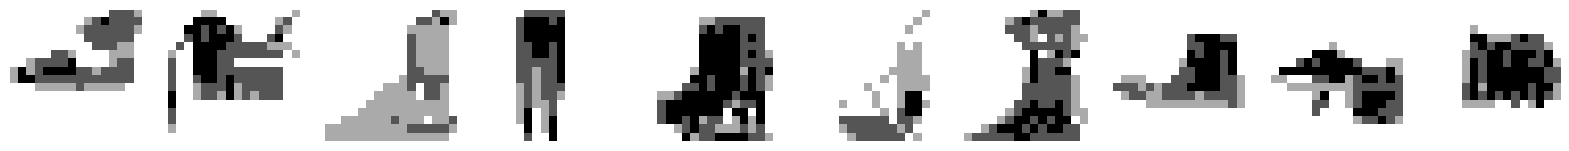

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.3320
Epoch 65/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3323
Saved to /content/images/generated_img_064.png


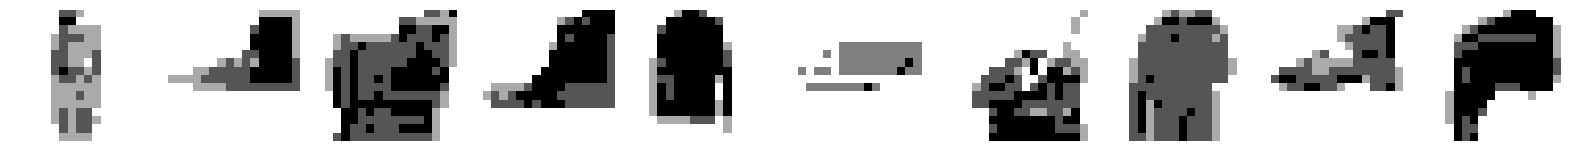

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3322
Epoch 66/150
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3303
Saved to /content/images/generated_img_065.png


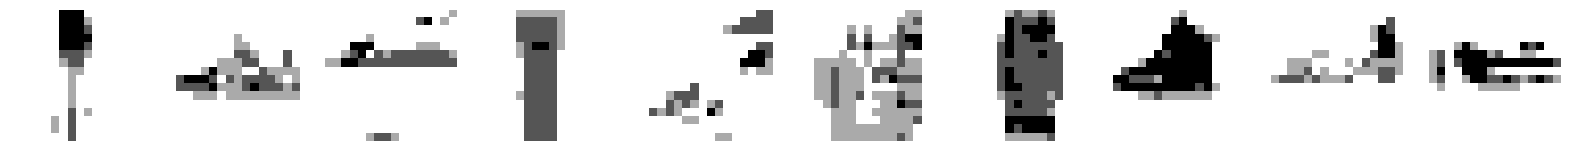

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3303
Epoch 67/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3309
Saved to /content/images/generated_img_066.png


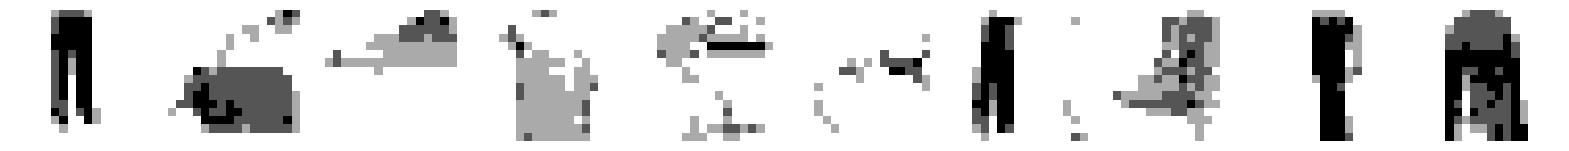

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - loss: 0.3309
Epoch 68/150
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3311
Saved to /content/images/generated_img_067.png


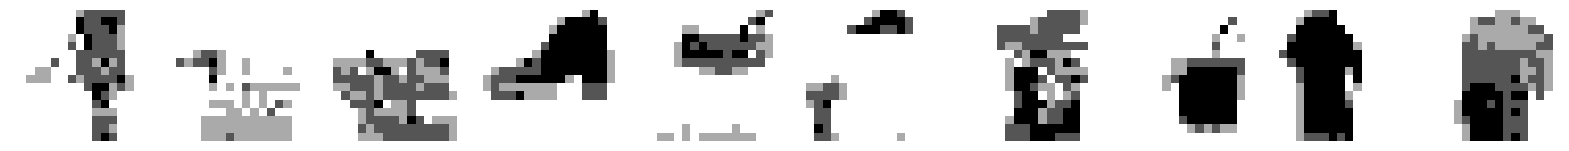

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.3311
Epoch 69/150
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3309
Saved to /content/images/generated_img_068.png


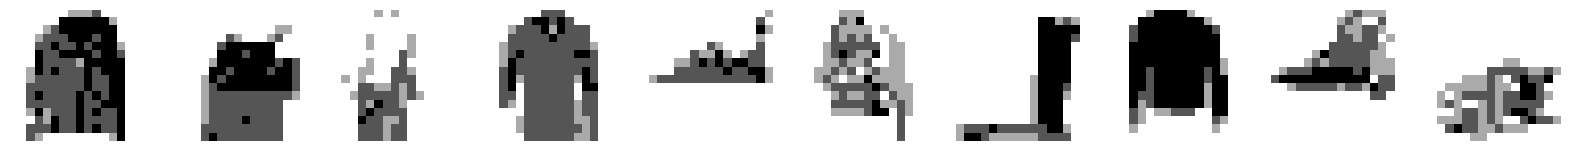

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3309
Epoch 70/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3309
Saved to /content/images/generated_img_069.png


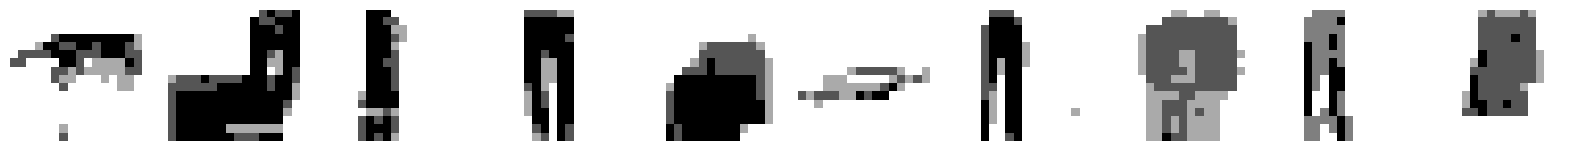

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 0.3309
Epoch 71/150
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3308
Saved to /content/images/generated_img_070.png


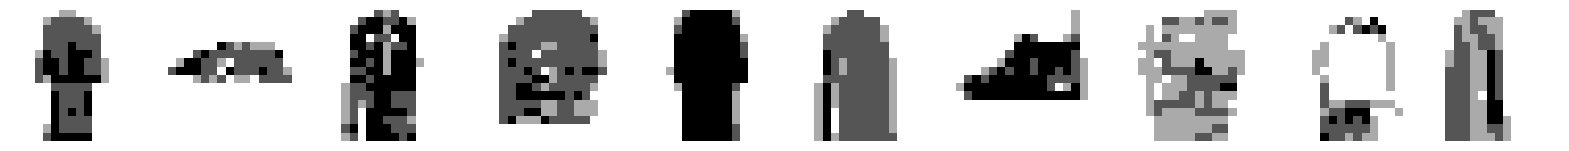

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3308
Epoch 72/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3301
Saved to /content/images/generated_img_071.png


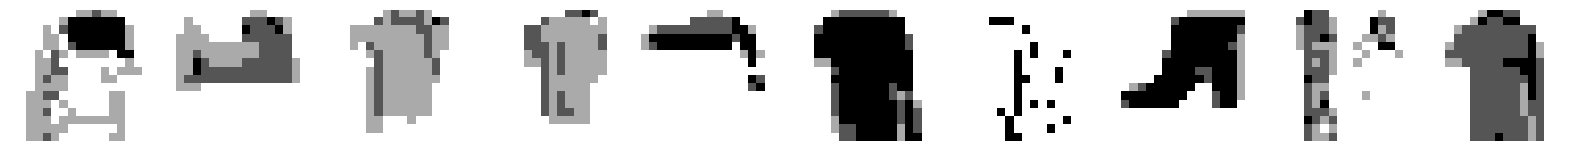

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - loss: 0.3301
Epoch 73/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3308
Saved to /content/images/generated_img_072.png


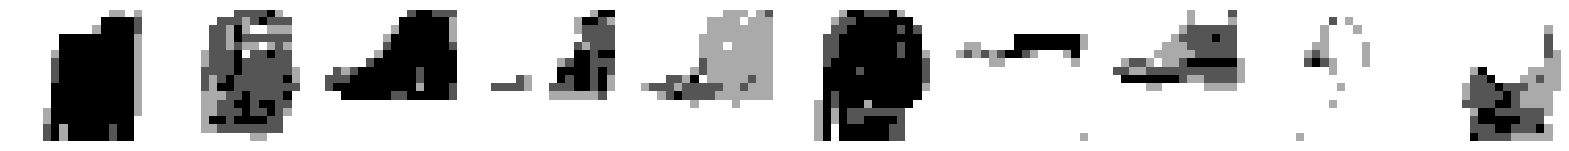

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.3308
Epoch 74/150
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3300
Saved to /content/images/generated_img_073.png


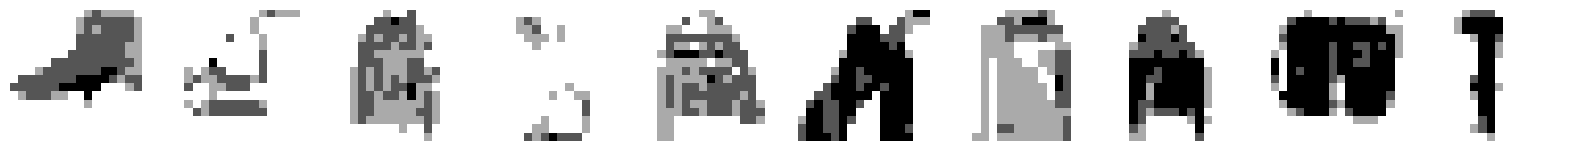

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3301
Epoch 75/150
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3305
Saved to /content/images/generated_img_074.png


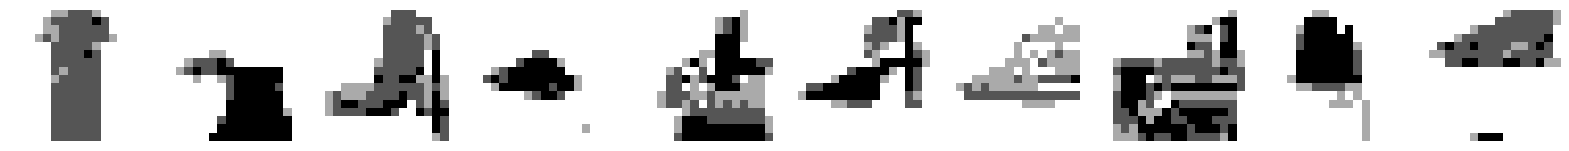

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3305
Epoch 76/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3302
Saved to /content/images/generated_img_075.png


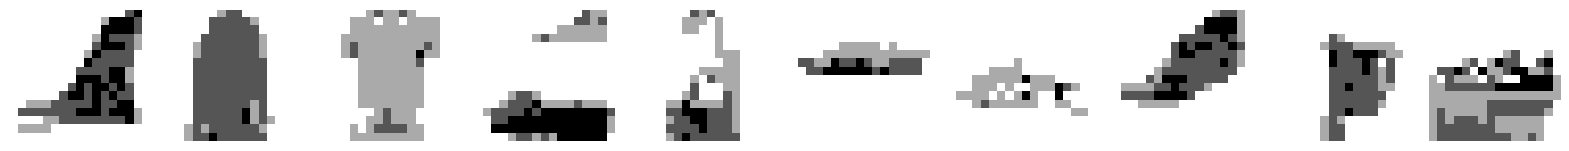

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3302
Epoch 77/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3297
Saved to /content/images/generated_img_076.png


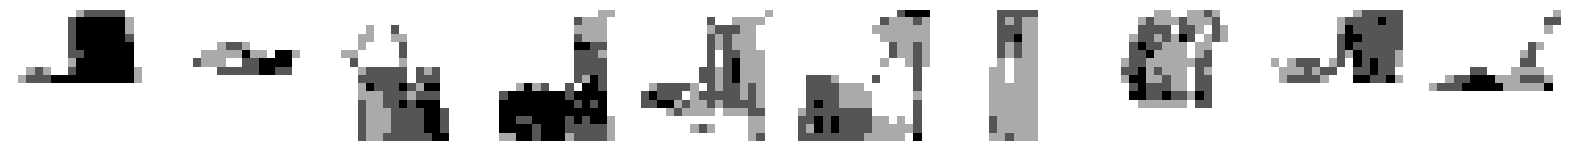

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - loss: 0.3297
Epoch 78/150
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3296
Saved to /content/images/generated_img_077.png


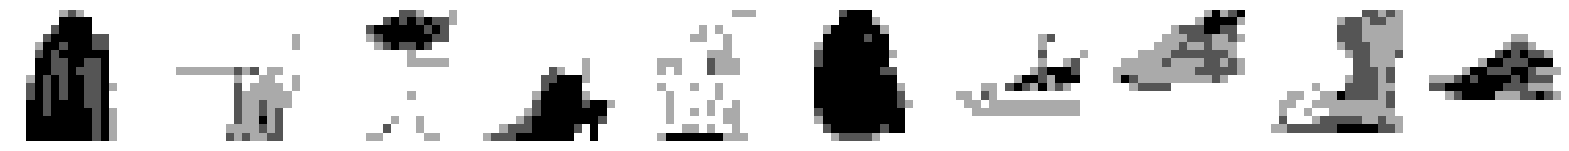

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.3296
Epoch 79/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3292
Saved to /content/images/generated_img_078.png


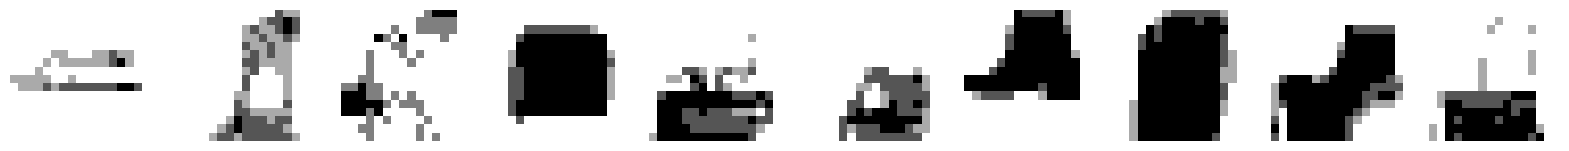

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 0.3292
Epoch 80/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3292
Saved to /content/images/generated_img_079.png


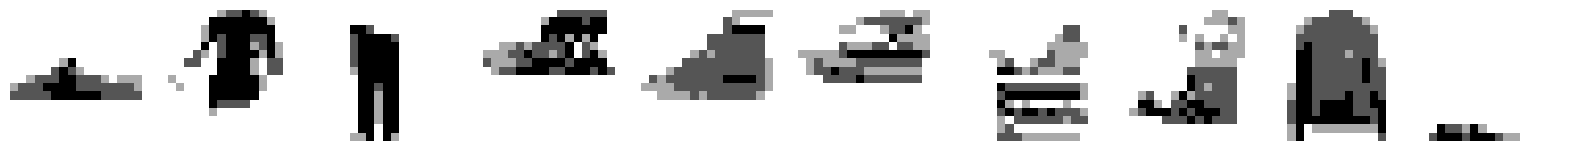

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3292
Epoch 81/150
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3291
Saved to /content/images/generated_img_080.png


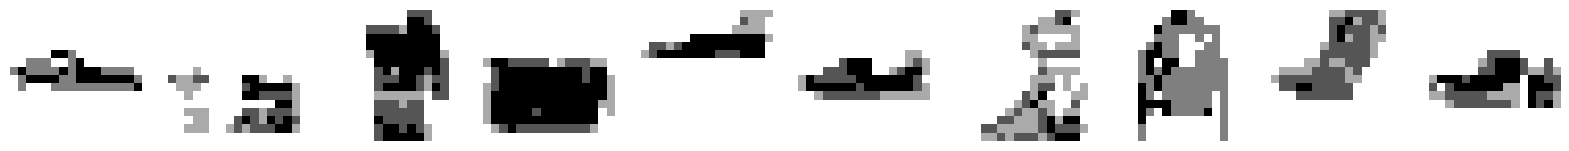

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.3291
Epoch 82/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3298
Saved to /content/images/generated_img_081.png


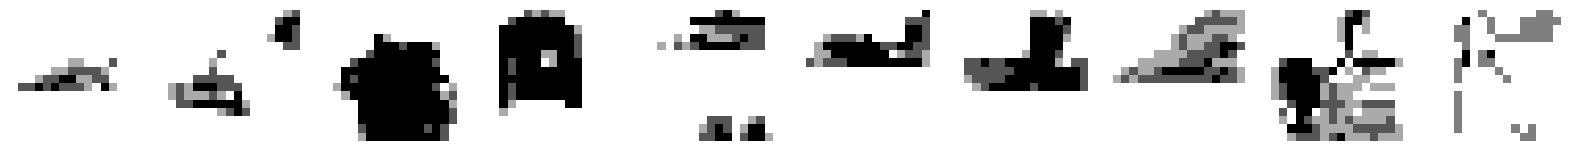

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.3298
Epoch 83/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3297
Saved to /content/images/generated_img_082.png


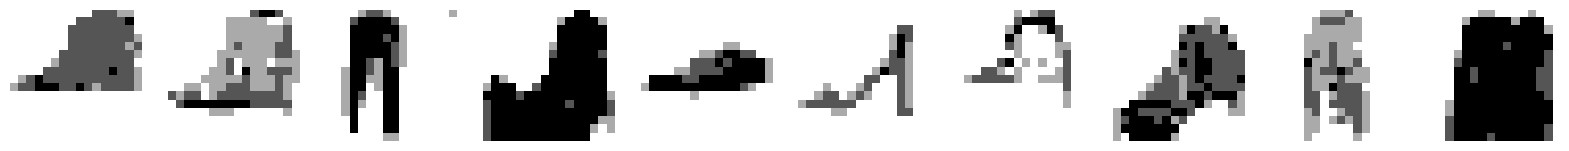

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3297
Epoch 84/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3276
Saved to /content/images/generated_img_083.png


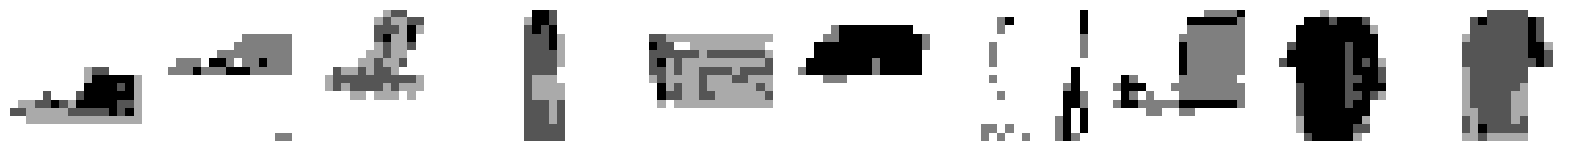

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3276
Epoch 85/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3279
Saved to /content/images/generated_img_084.png


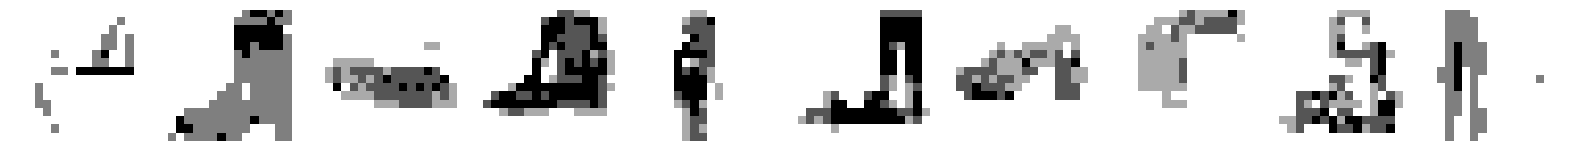

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3279
Epoch 86/150
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3278
Saved to /content/images/generated_img_085.png


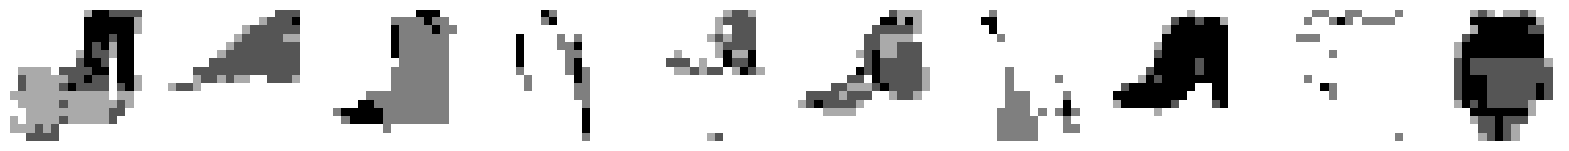

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - loss: 0.3278
Epoch 87/150
461/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3293
Saved to /content/images/generated_img_086.png


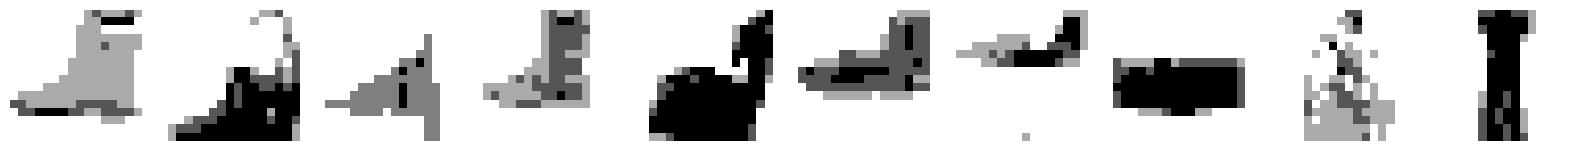

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3293
Epoch 88/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3271
Saved to /content/images/generated_img_087.png


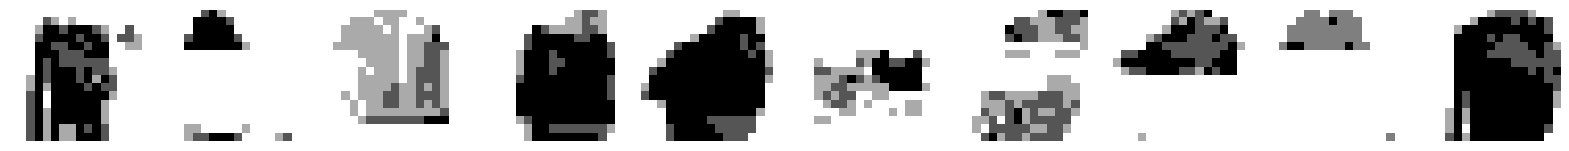

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 0.3271
Epoch 89/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3276
Saved to /content/images/generated_img_088.png


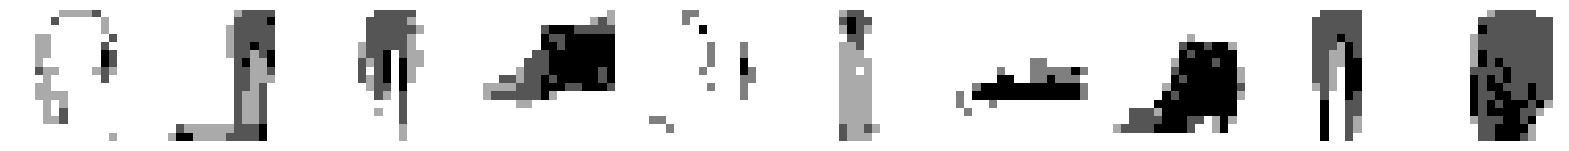

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3276
Epoch 90/150
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3277
Saved to /content/images/generated_img_089.png


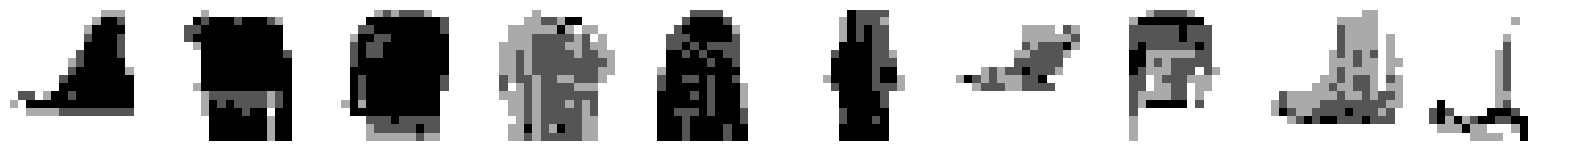

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3277
Epoch 91/150
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3276
Saved to /content/images/generated_img_090.png


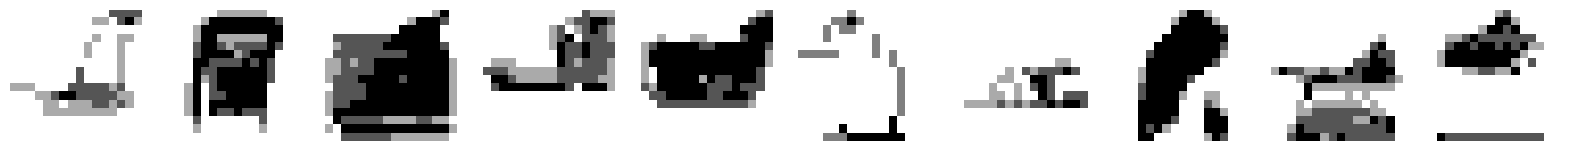

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - loss: 0.3276
Epoch 92/150
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3277
Saved to /content/images/generated_img_091.png


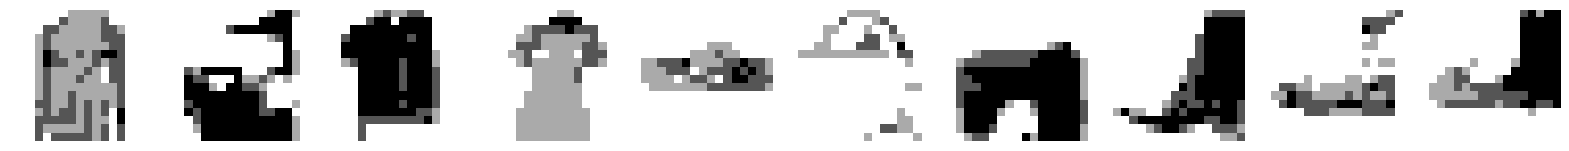

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.3277
Epoch 93/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3268
Saved to /content/images/generated_img_092.png


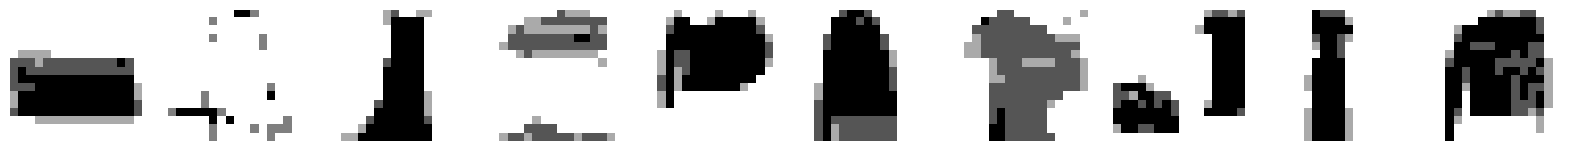

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3268
Epoch 94/150
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3270
Saved to /content/images/generated_img_093.png


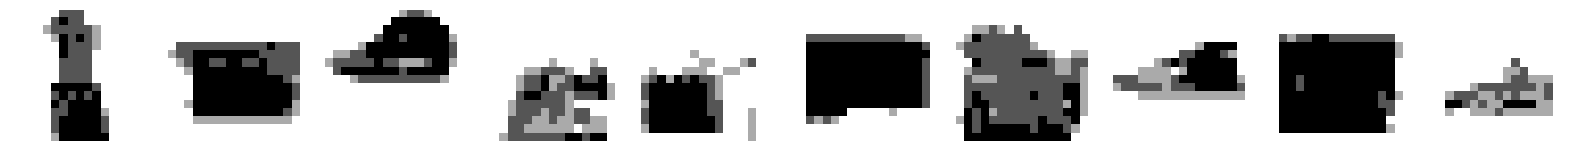

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 0.3270
Epoch 95/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3273
Saved to /content/images/generated_img_094.png


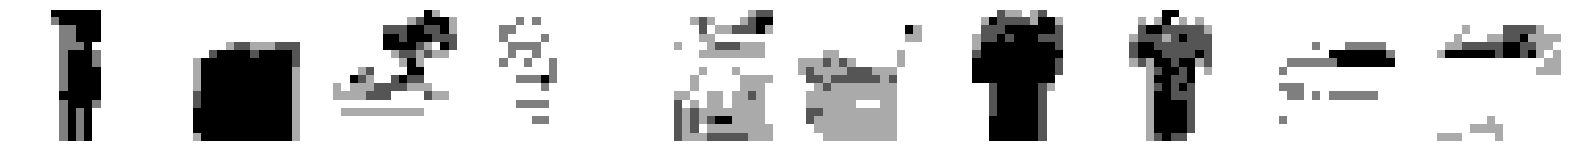

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3273
Epoch 96/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3263
Saved to /content/images/generated_img_095.png


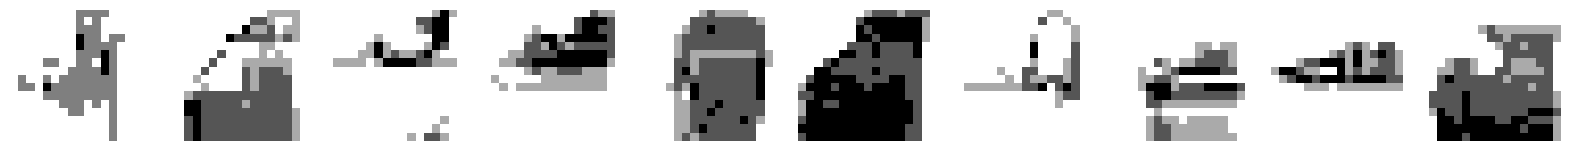

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - loss: 0.3263
Epoch 97/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3276
Saved to /content/images/generated_img_096.png


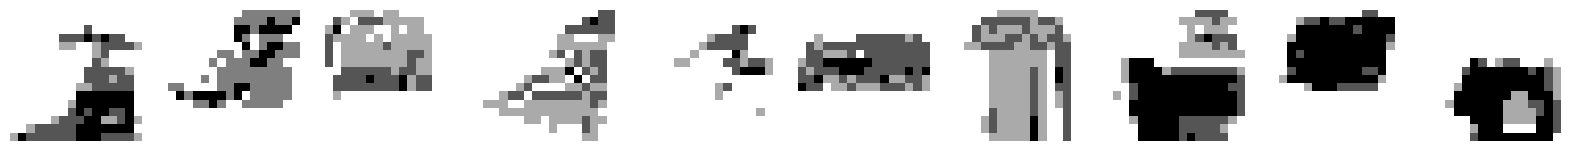

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.3276
Epoch 98/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3264
Saved to /content/images/generated_img_097.png


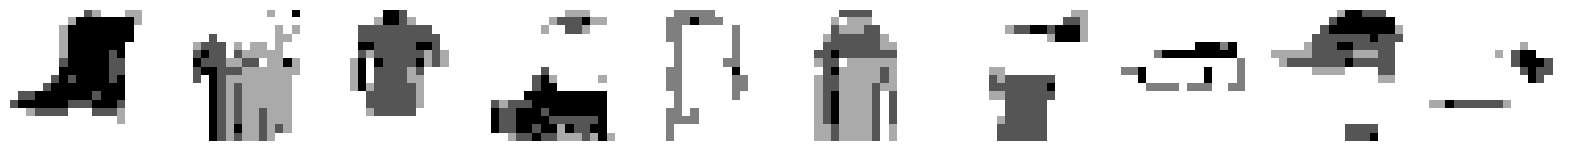

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 0.3264
Epoch 99/150
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3269
Saved to /content/images/generated_img_098.png


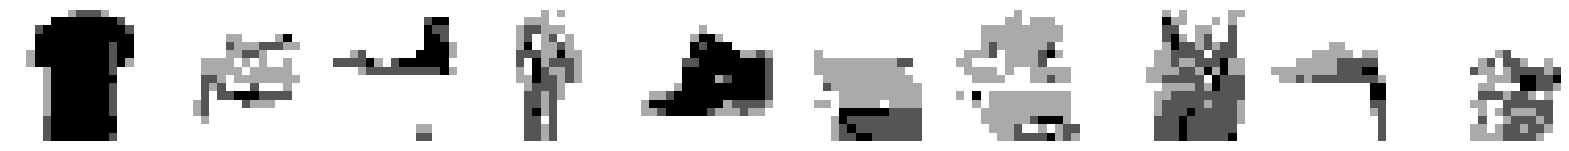

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3269
Epoch 100/150
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3267
Saved to /content/images/generated_img_099.png


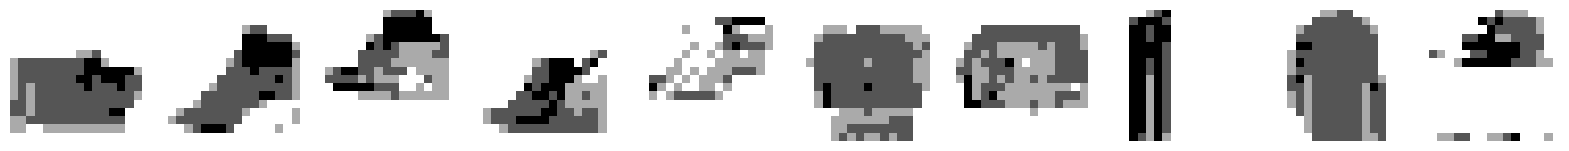

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - loss: 0.3267
Epoch 101/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3262
Saved to /content/images/generated_img_100.png


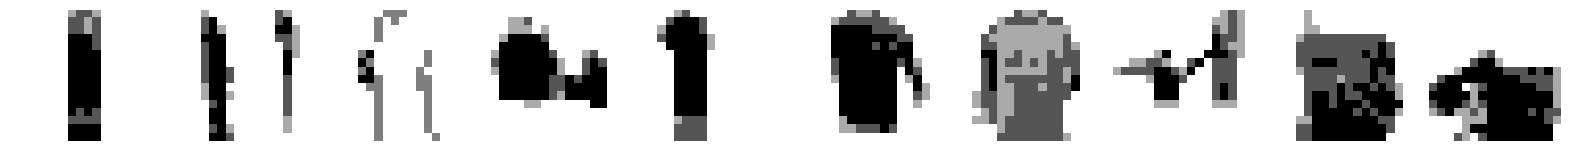

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.3262
Epoch 102/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3272
Saved to /content/images/generated_img_101.png


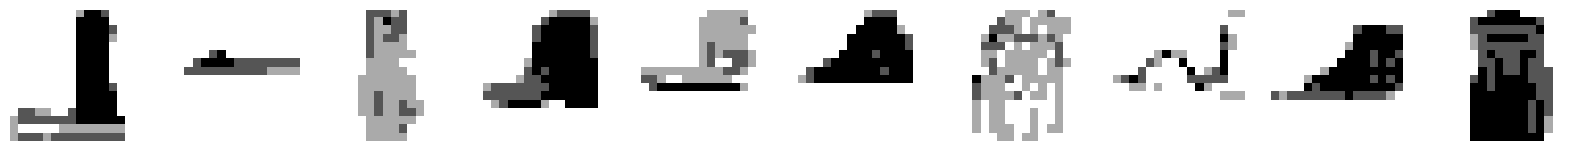

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3272
Epoch 103/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3269
Saved to /content/images/generated_img_102.png


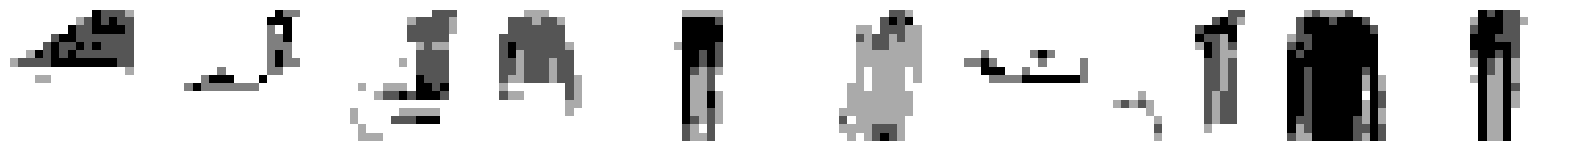

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 0.3269
Epoch 104/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3267
Saved to /content/images/generated_img_103.png


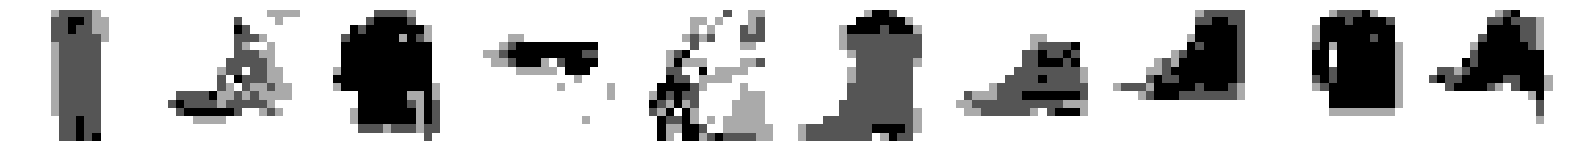

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 0.3267
Epoch 105/150
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3264
Saved to /content/images/generated_img_104.png


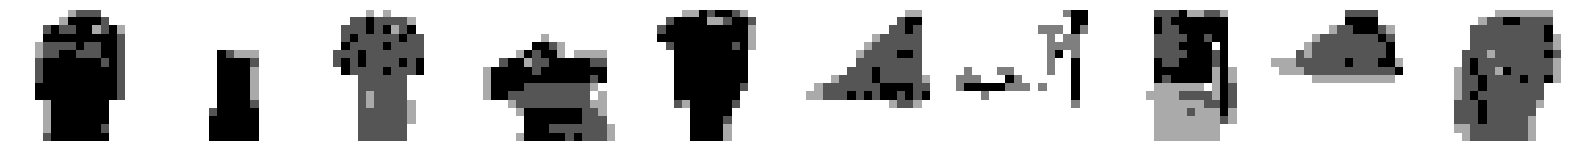

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - loss: 0.3264
Epoch 106/150
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3264
Saved to /content/images/generated_img_105.png


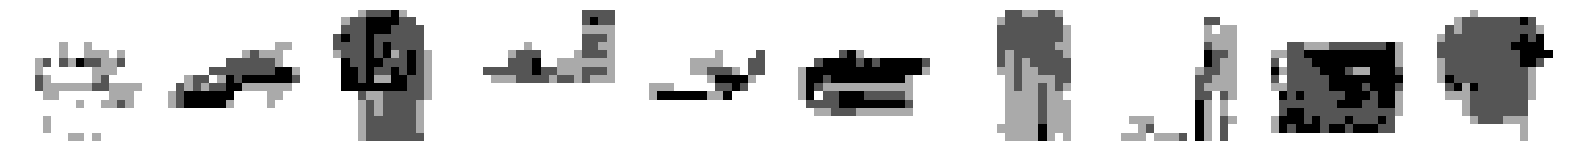

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.3264
Epoch 107/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3270
Saved to /content/images/generated_img_106.png


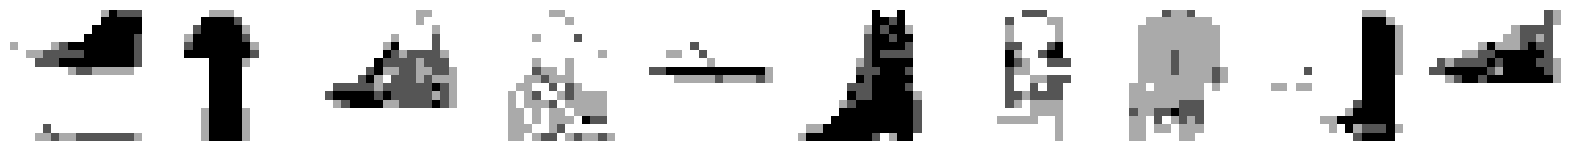

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3270
Epoch 108/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3262
Saved to /content/images/generated_img_107.png


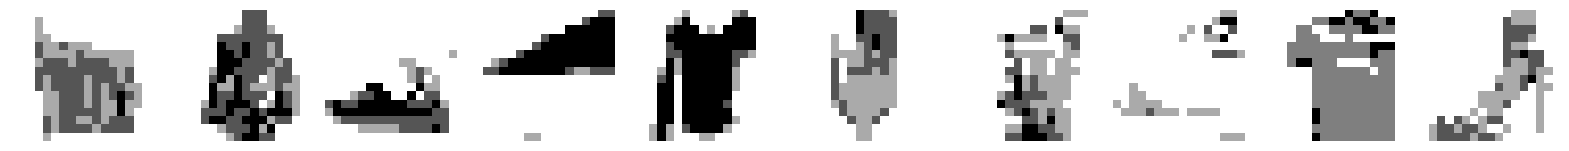

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 0.3263
Epoch 109/150
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3256
Saved to /content/images/generated_img_108.png


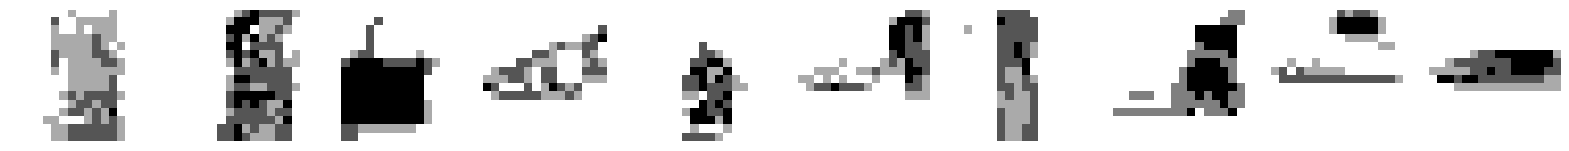

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3256
Epoch 110/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3269
Saved to /content/images/generated_img_109.png


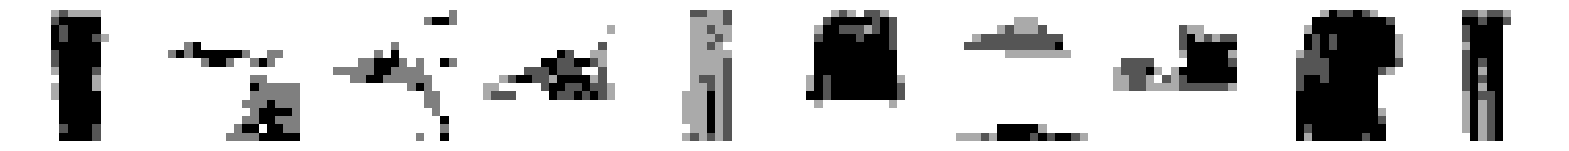

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - loss: 0.3269
Epoch 111/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3264
Saved to /content/images/generated_img_110.png


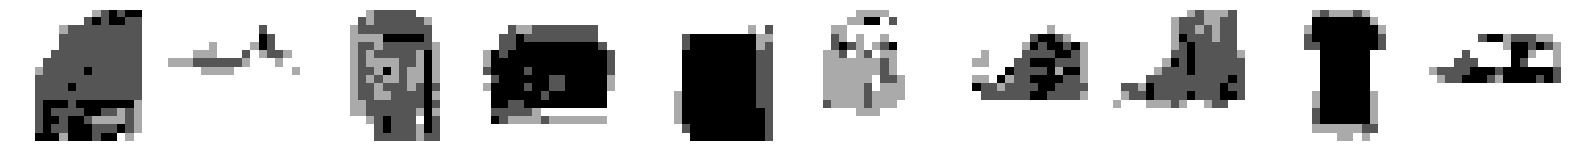

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.3264
Epoch 112/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3262
Saved to /content/images/generated_img_111.png


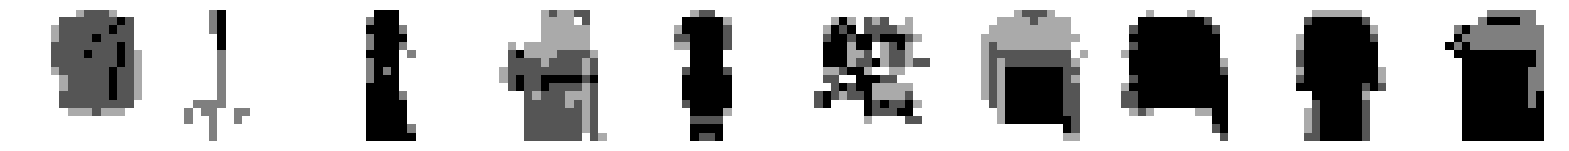

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3262
Epoch 113/150
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3254
Saved to /content/images/generated_img_112.png


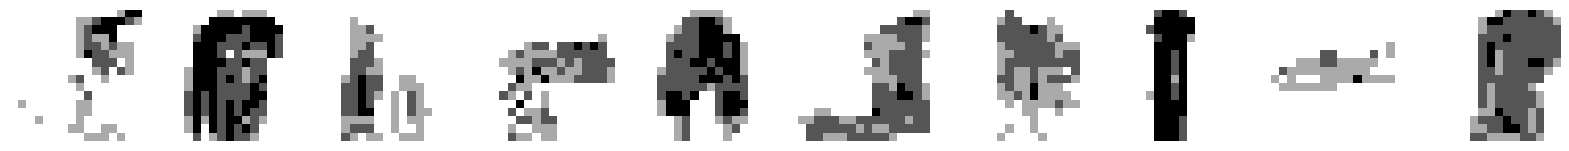

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 0.3254
Epoch 114/150
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3254
Saved to /content/images/generated_img_113.png


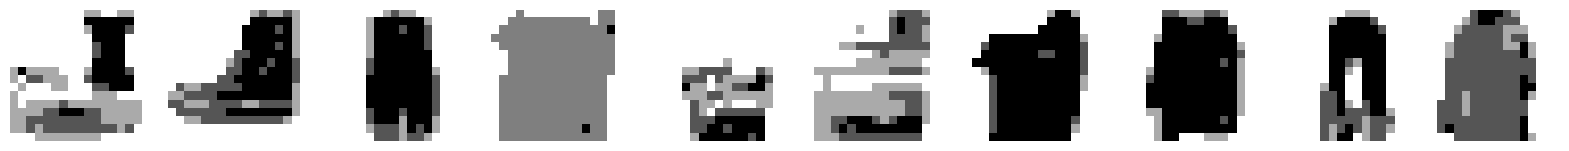

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.3254
Epoch 115/150
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3246
Saved to /content/images/generated_img_114.png


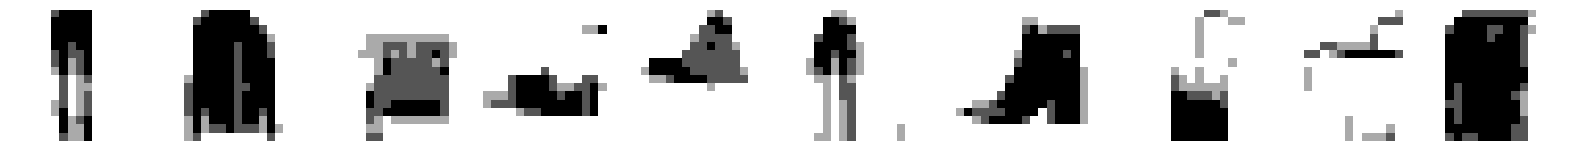

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - loss: 0.3246
Epoch 116/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3247
Saved to /content/images/generated_img_115.png


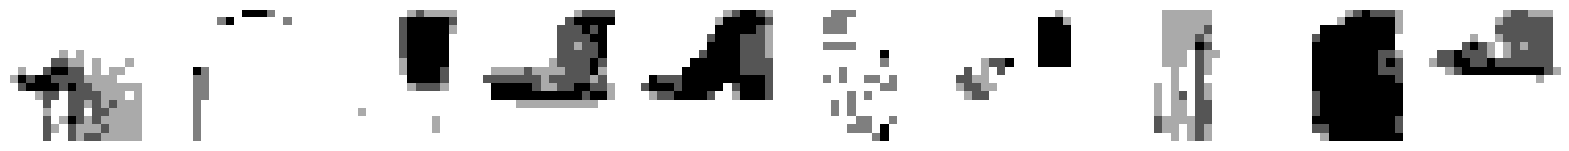

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.3247
Epoch 117/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3249
Saved to /content/images/generated_img_116.png


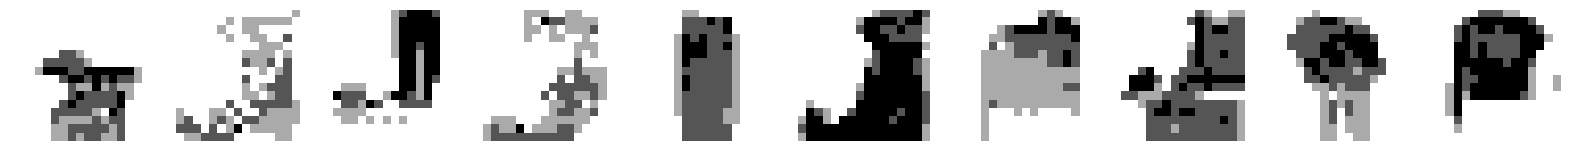

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3249
Epoch 118/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3258
Saved to /content/images/generated_img_117.png


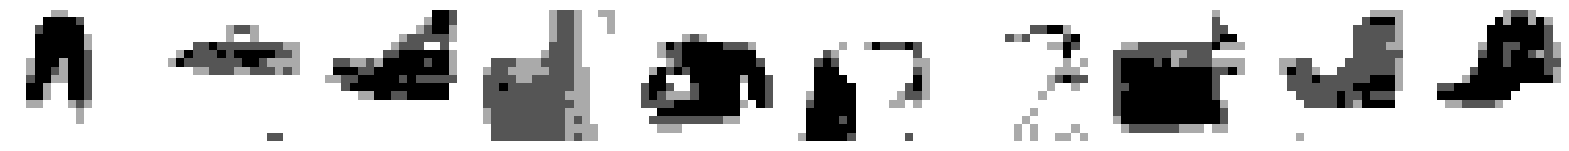

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3258
Epoch 119/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3249
Saved to /content/images/generated_img_118.png


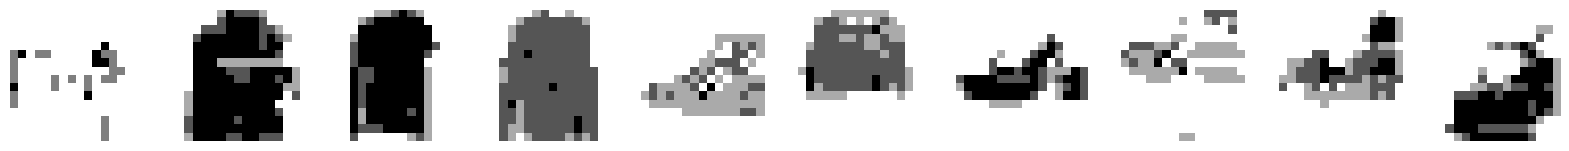

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - loss: 0.3249
Epoch 120/150
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3244
Saved to /content/images/generated_img_119.png


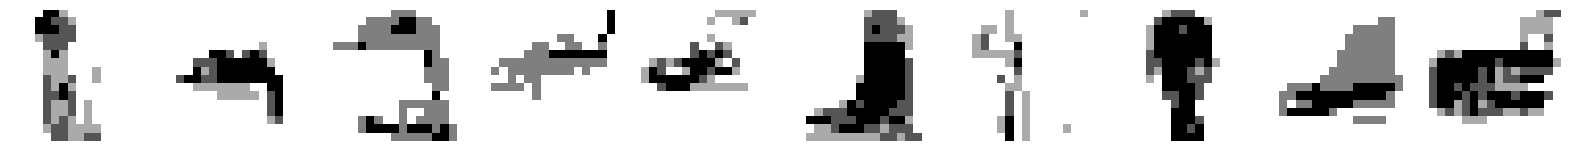

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.3244
Epoch 121/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3247
Saved to /content/images/generated_img_120.png


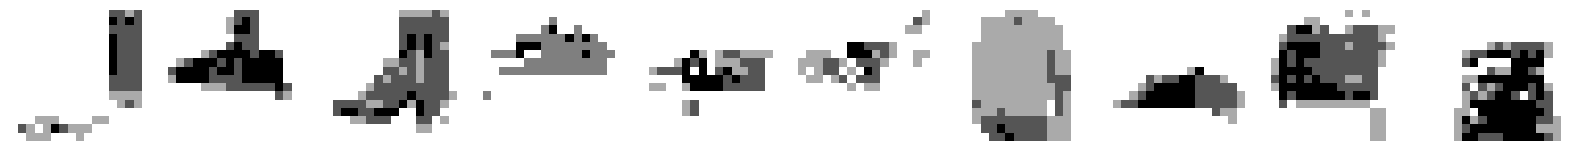

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3247
Epoch 122/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3246
Saved to /content/images/generated_img_121.png


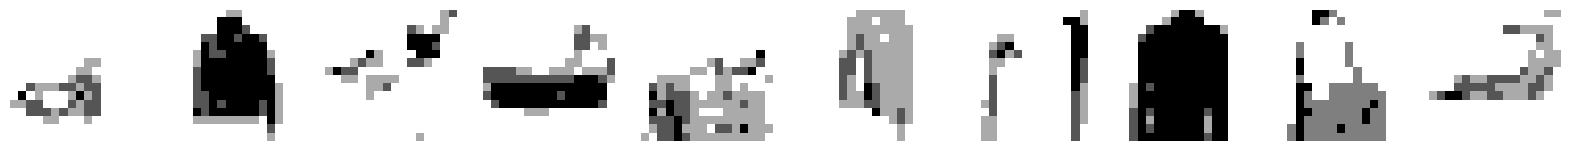

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 0.3246
Epoch 123/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3261
Saved to /content/images/generated_img_122.png


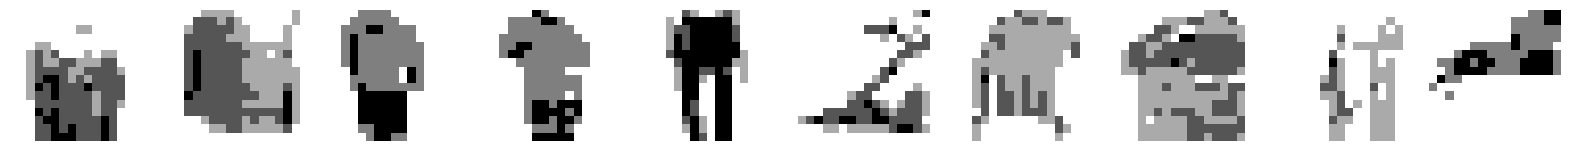

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3261
Epoch 124/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3242
Saved to /content/images/generated_img_123.png


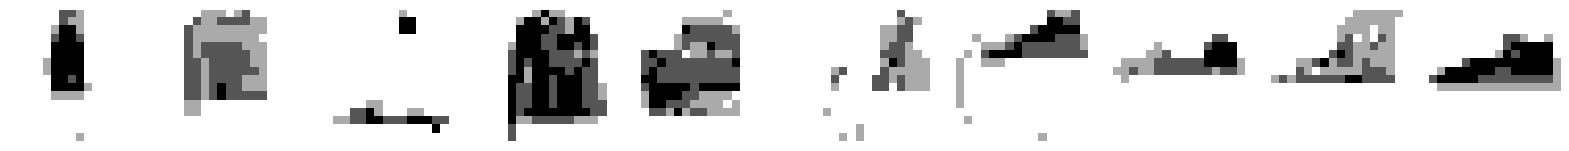

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - loss: 0.3242
Epoch 125/150
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3257
Saved to /content/images/generated_img_124.png


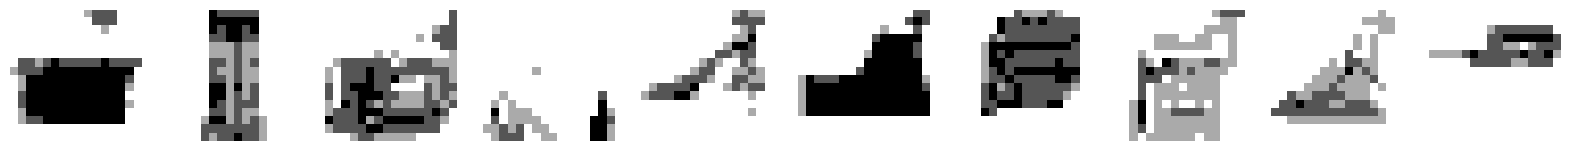

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.3257
Epoch 126/150
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3245
Saved to /content/images/generated_img_125.png


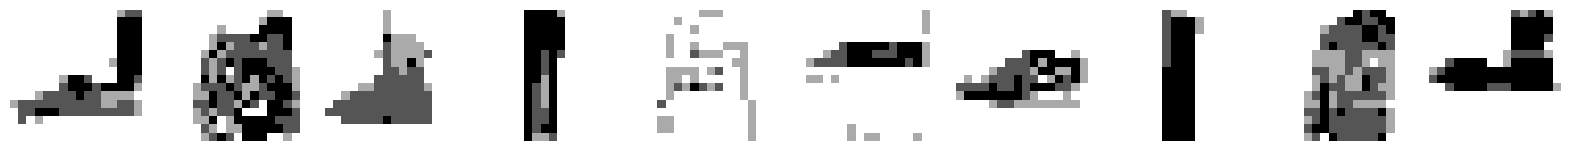

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3245
Epoch 127/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3243
Saved to /content/images/generated_img_126.png


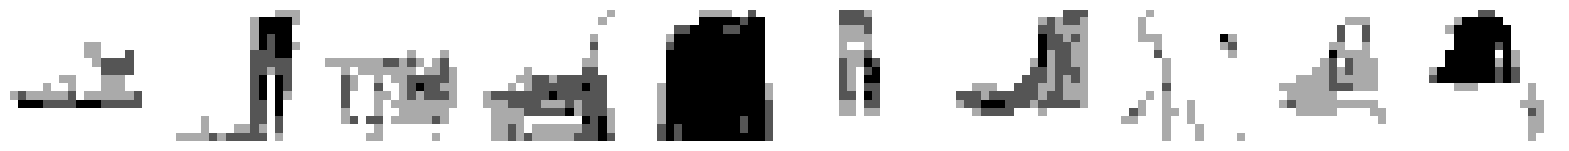

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 0.3243
Epoch 128/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3240
Saved to /content/images/generated_img_127.png


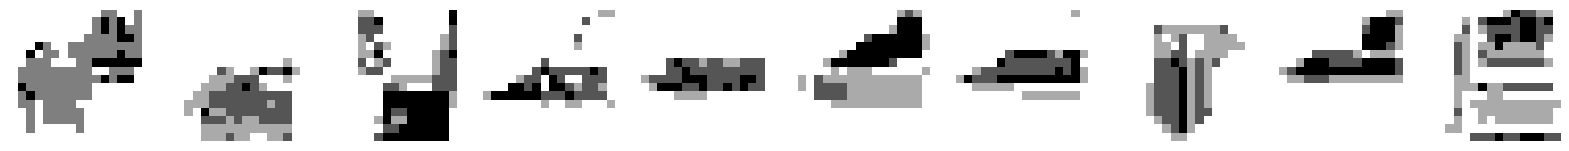

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3240
Epoch 129/150
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3236
Saved to /content/images/generated_img_128.png


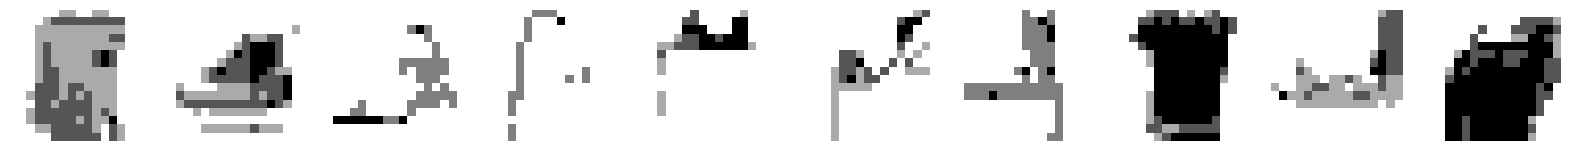

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - loss: 0.3236
Epoch 130/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3249
Saved to /content/images/generated_img_129.png


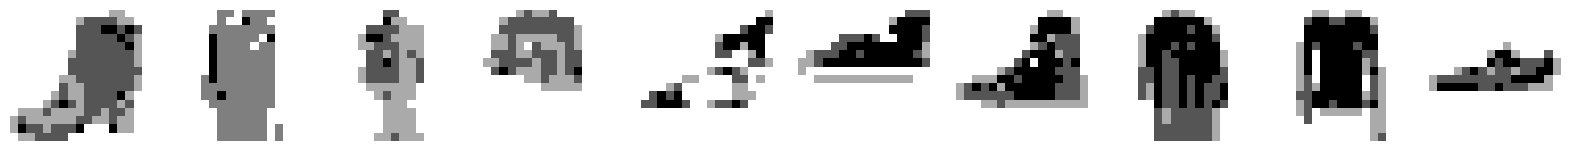

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.3249
Epoch 131/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3237
Saved to /content/images/generated_img_130.png


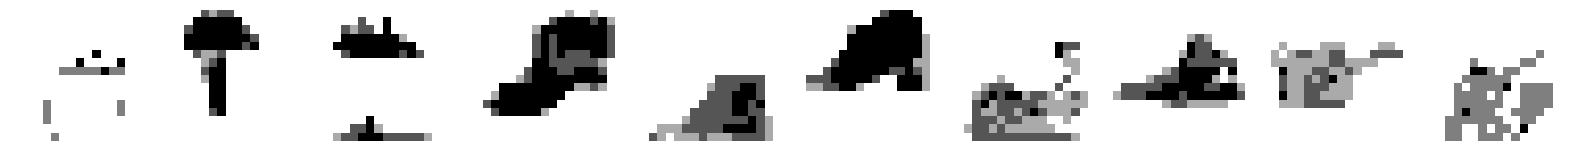

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3237
Epoch 132/150
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3235
Saved to /content/images/generated_img_131.png


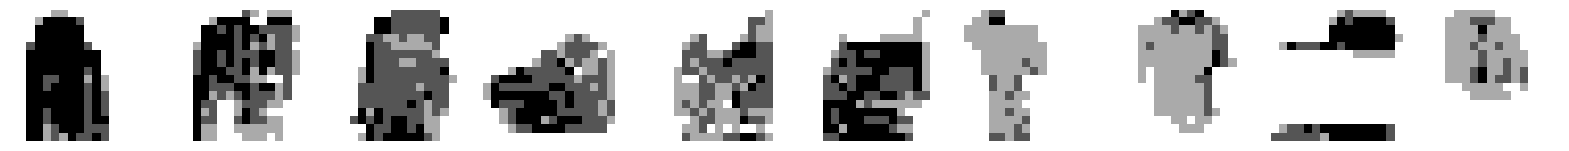

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3235
Epoch 133/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3238
Saved to /content/images/generated_img_132.png


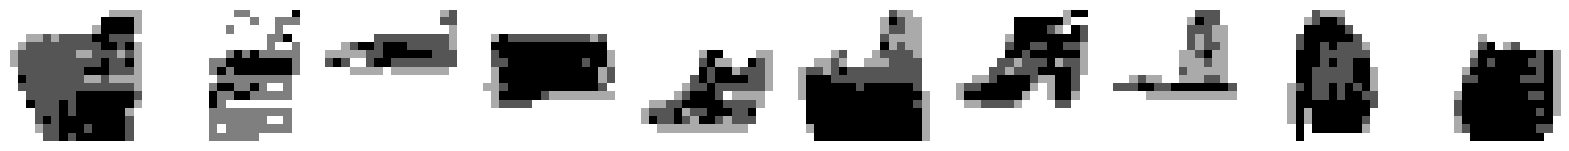

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - loss: 0.3239
Epoch 134/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3249
Saved to /content/images/generated_img_133.png


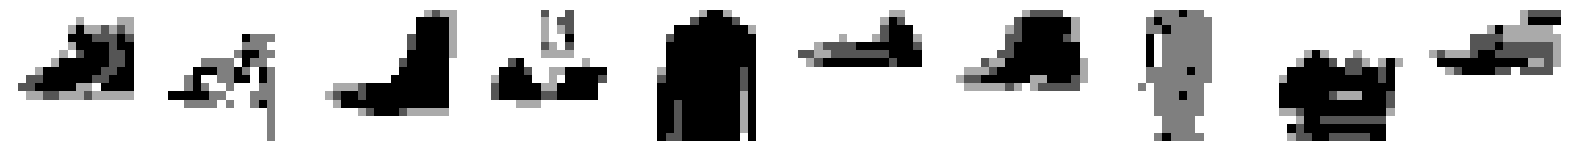

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - loss: 0.3249
Epoch 135/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3234
Saved to /content/images/generated_img_134.png


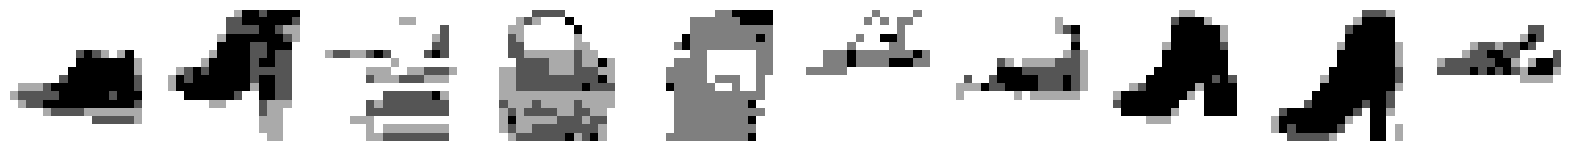

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.3234
Epoch 136/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3237
Saved to /content/images/generated_img_135.png


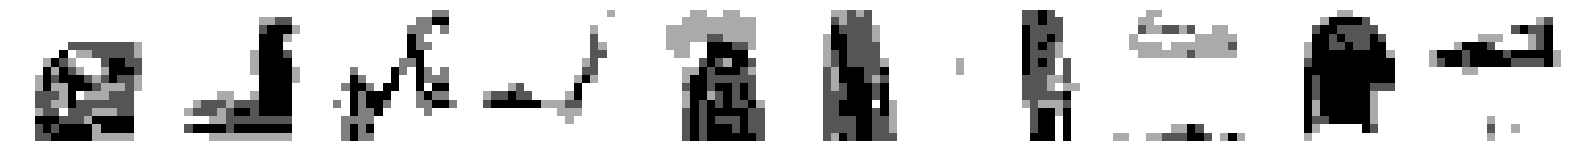

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3237
Epoch 137/150
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3238
Saved to /content/images/generated_img_136.png


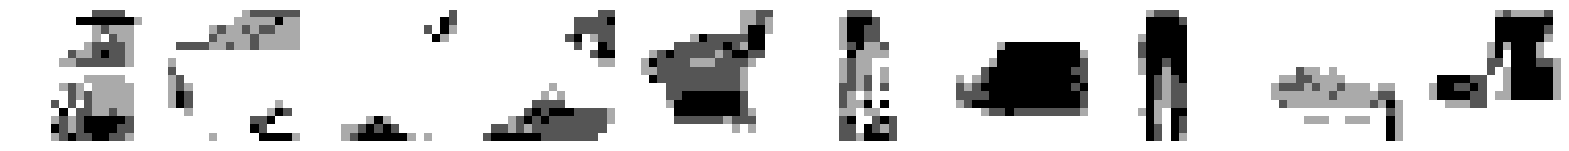

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3238
Epoch 138/150
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3229
Saved to /content/images/generated_img_137.png


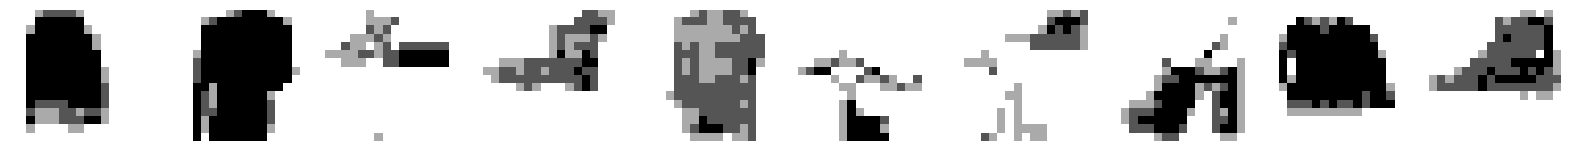

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - loss: 0.3229
Epoch 139/150
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3245
Saved to /content/images/generated_img_138.png


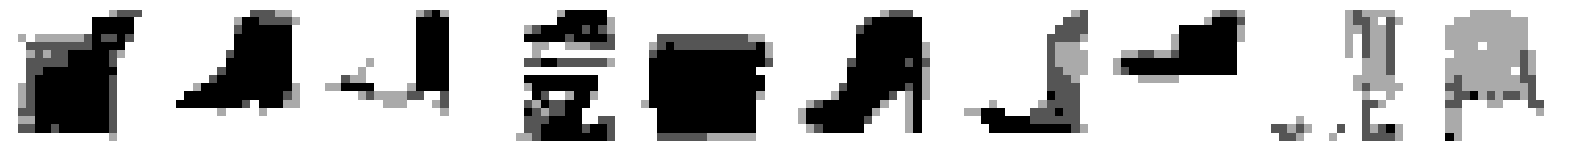

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.3245
Epoch 140/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3233
Saved to /content/images/generated_img_139.png


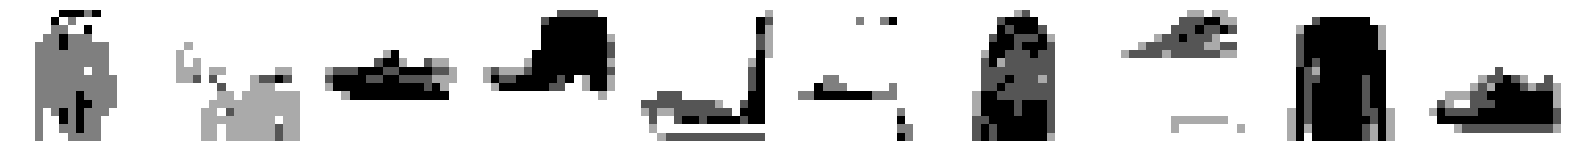

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3233
Epoch 141/150
461/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3229
Saved to /content/images/generated_img_140.png


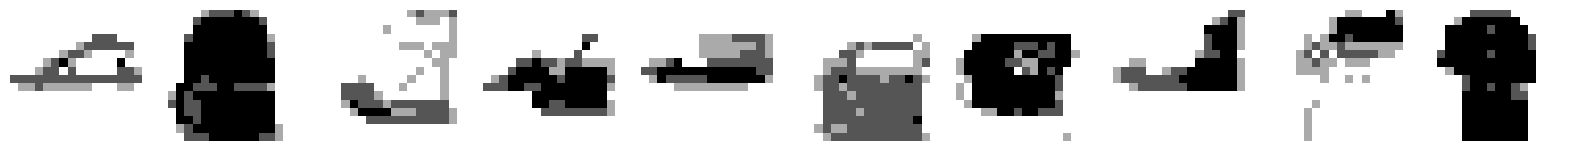

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3229
Epoch 142/150
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3229
Saved to /content/images/generated_img_141.png


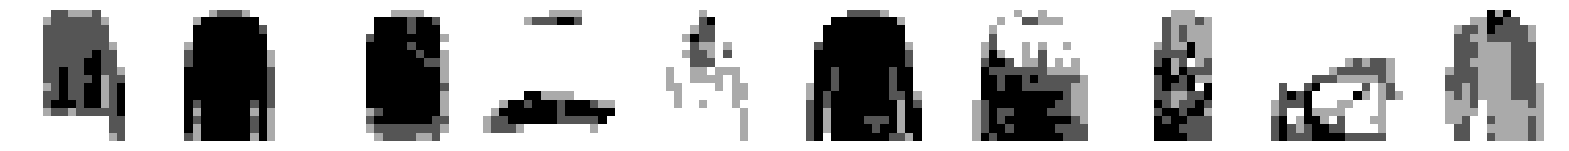

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3229
Epoch 143/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3239
Saved to /content/images/generated_img_142.png


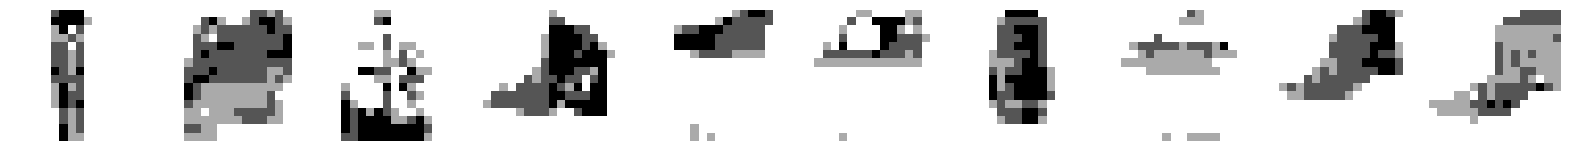

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - loss: 0.3239
Epoch 144/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3232
Saved to /content/images/generated_img_143.png


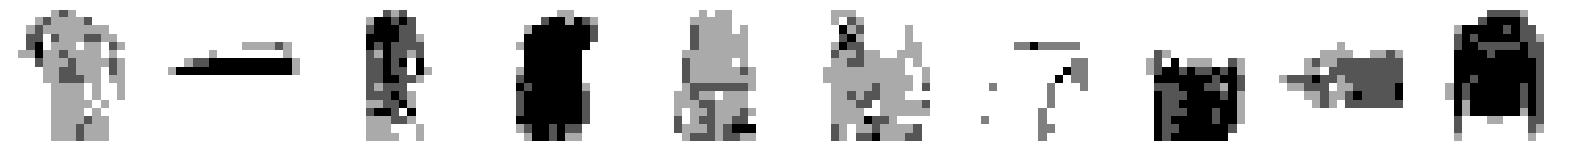

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - loss: 0.3232
Epoch 145/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3245
Saved to /content/images/generated_img_144.png


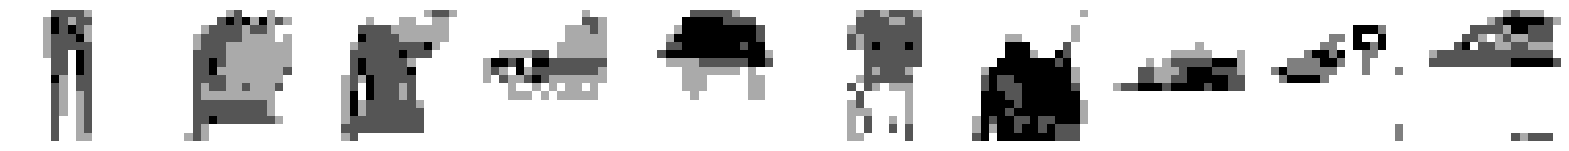

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3245
Epoch 146/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3230
Saved to /content/images/generated_img_145.png


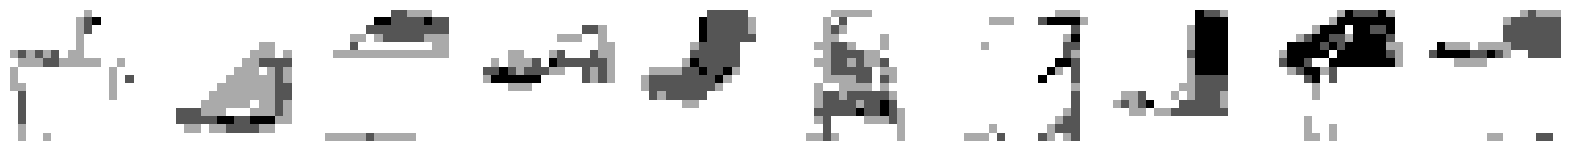

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3230
Epoch 147/150
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3227
Saved to /content/images/generated_img_146.png


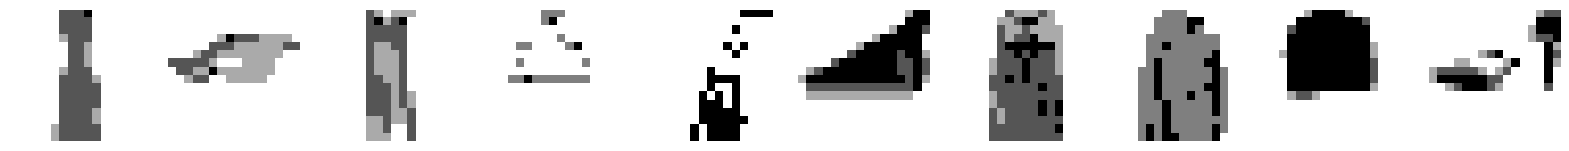

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - loss: 0.3227
Epoch 148/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3228
Saved to /content/images/generated_img_147.png


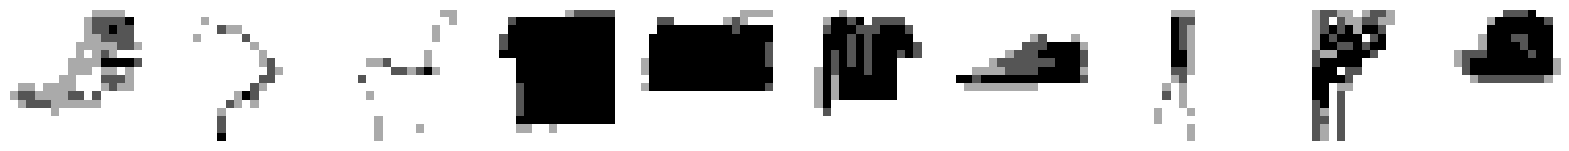

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - loss: 0.3228
Epoch 149/150
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3227
Saved to /content/images/generated_img_148.png


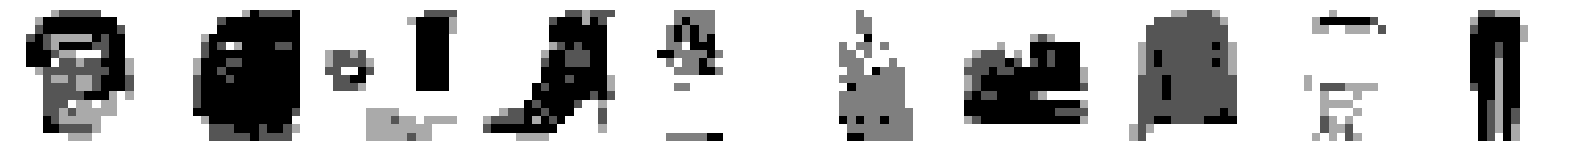

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.3227
Epoch 150/150
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3232
Saved to /content/images/generated_img_149.png


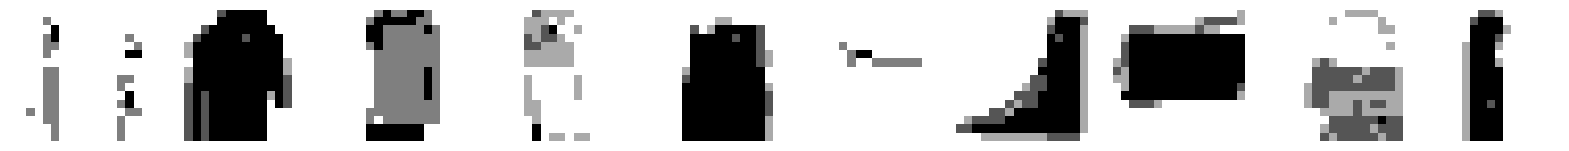

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.3232


In [14]:
pixel_cnn.fit(
    input_data,
    output_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[tensorboard_callback, img_generator_callback],
)